<a href="https://colab.research.google.com/github/fshemaj/Machine-Learning-Project/blob/master/CBB_RAPM/CBB_Rapm_Bayesian_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Setup

In [ ]:
# This project is based on Lee Richardson's paper - https://arxiv.org/pdf/1810.08032

In [ ]:
# Matt intern's rapm notebook for reference - https://github.com/NicholasCanova/cbb-airflow/blob/master/notebooks/rapm.ipynb

In [ ]:
# install sparseqr to efficiently compute QR decomposition of sparse matrices - remove if not performing QR decomp.
# !pip install git+https://github.com/yig/PySPQR.git  # or pip install sparseqr
# !sudo apt-get install build-essential
# !sudo apt-get install libsuitesparse-dev

In [1]:
import sys
import os
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pytensor
import pytensor.tensor as pt
import pytensor.sparse as sparse
import scipy.sparse as sp
import scipy.linalg as la
from scipy.stats import poisson
import scipy.sparse.linalg as spla
from scipy.sparse import lil_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from google.oauth2 import service_account
from google.cloud import bigquery

# # qr decomp. libraries
# import sparseqr
# print(sparseqr.__version__)

In [2]:
# Check versions!
!python --version

Python 3.10.12


In [3]:
print(pm.__version__)
print(np.__version__)
print(pd.__version__)
import scipy
print(scipy.__version__)
print(az.__version__)
print(pytensor.__version__)

5.10.4
1.26.4
2.1.4
1.13.1
0.18.0
2.18.6


In [4]:
# set GCP credentials
#os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/fjoralbashemaj/.gcp_keys/cbbanalytics-2df10a38a3fa.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'cbbanalytics-2df10a38a3fa.json'

In [5]:
# connect to bigquery
bq = bigquery.Client()

In [6]:
# helper func to compute mse/mae at stint level
def compute_stint_metrics(df, preds):
  stint_df = df.copy()
  stint_df['y_pred'] = preds
  stint_df = stint_df.groupby(['gameId','offOnCtRapm', 'defOnCtRapm'])\
  .agg({'ptsScored': 'sum', 'y_pred': 'sum', 'possNum':'size'}).reset_index().rename(columns={'possNum':'nr_poss'})
  mse = mean_squared_error(stint_df['ptsScored'], stint_df['y_pred'])
  mae = mean_absolute_error(stint_df['ptsScored'], stint_df['y_pred'])
  print(f"MSE: {mse:.3f}")
  print(f"MAE: {mae:.3f}")
  # are we correctly predicting when nr points scores >= nr. of possessions in the stint?
  cl_error = 1-accuracy_score(np.round(stint_df['y_pred']) >= stint_df['nr_poss'], stint_df['ptsScored'] >= stint_df['nr_poss'])
  print('binary classification error', cl_error)
  return stint_df

In [7]:
# Call `ascendingPlayerIds()` function on home and away player IDs to sort into ascending-ordered strings
# This is done in order to group together identical stints

def ascendingPlayerIds(id1, id2, id3, id4, id5):
  final_str = ""
  not_yet_used = np.array([id1, id2, id3, id4, id5])
  while len(not_yet_used) > 0:
      min_id = not_yet_used.min()
      final_str = final_str + str(min_id) + ";"
      not_yet_used = np.delete(not_yet_used, np.where(not_yet_used == min_id))
  return final_str


In [7]:
# --player mins for whole season
# with
#   t1 as (
#     select mins, playerId, fullName
#     from models.gs__player_agg_stats
#     where competitionId = 36046 and divisionId = 1 and scope = 'season'
#   ),

# --player total mins up to a certain date in the season
#   t2 as (
#     select
#       playerId
#       ,fullName
#       ,sum(mins) as mins
#     from models.gs__player_game_stats
#     where competitionId = 36046 and divisionId = 1 and gameDate <= '2024-01-01'
#     group by 1,2 order by 3 desc
#   ),

# --conference ortg and drtg ratings for whole season
#   conf_str as (
#     select
#       conferenceId, conferenceShortName, conferenceLongName, ortg, drtg, netRtg
#     from models.gs__conference_agg_stats
#     where competitionId = 36046 and divisionId = 1 and scope = 'season' and isOffense is true
#     order by netRtg desc
#   )

# -- select * from t2
# select * from conf_str

# 1. Men's 2023-2024 season data, conference 74 (pac-12)

In [10]:
# We'll start with men's 2023-2024 season data, division 1 only, for fitting the baysesian model

In [11]:
# Query below is taken from - https://github.com/NicholasCanova/cbb-dbt/blob/8a162a842df9be8c38db5aa12926be4e528c4bbc/unused/models_unused/not_ready_yet/gs__poss_rapm_v2.sql#L4


## Load possession and prior metric data

In [12]:
# 1. Get Possession data

# git dbt - https://github.com/NicholasCanova/cbb-dbt/blob/8a162a842df9be8c38db5aa12926be4e528c4bbc/models/output/gs__possessions.sql#L291


In [8]:
# only division1 teams in PAC-12 conference (id 74) - smaller query
poss_query = '''
-- filter possessions where both home and away teams are in pac-12 (conf 74)
with possessions as (
  select
    a.*
    ,b.conferenceId as home_conf
    ,c.conferenceId as away_conf
    ,case when a.teamId = a.homeId then b.conferenceId else c.conferenceId end as offense_conf -- teamid is id of team in possession!
    ,case when a.teamId = a.awayId then b.conferenceId else c.conferenceId end as defense_conf
  from models.gs__possessions as a
  left join models.gs__enh_competition_teams as b on a.competitionId = b.competitionId and a.homeId = b.teamId
  left join models.gs__enh_competition_teams as c on a.competitionId = c.competitionId and a.awayId = c.teamId
  where 1 = 1
    and a.competitionId = 36046
    and a.conferenceId = 74
    and b.divisionId = 1 and b.conferenceId = 74
    and c.divisionId = 1 and c.conferenceId = 74
),

poss_rapm as (
  select
    gameId
    ,possNum
    ,competitionId
    ,offense_conf
    ,defense_conf
    ,homeId
    ,awayId
    ,teamId
    ,ptsScored
    ,period
    ,isFga
    ,fga
    ,fta
    ,orb
    ,fga - cast(isFgm as INT64) as rebOpps
    ,if(result like "%turnover%", 1, 0) as isTurnover
    ,case
      when ptsScored = 0 and possLineupEnd is not null then possLineupEnd
      when ptsScored > 0 and possLineupFgm is not null then possLineupFgm
      when ptsScored > 0 and possLineupSfl is not null then possLineupSfl
      when possLineupStart is not null then possLineupStart
      else null
    end as offOnCtRapmRaw
    ,case
      when ptsScored = 0 and defLineupEnd is not null then defLineupEnd
      when ptsScored > 0 and defLineupFgm is not null then defLineupFgm
      when ptsScored > 0 and defLineupSfl is not null then defLineupSfl
      when defLineupStart is not null then defLineupStart
      else null
    end as defOnCtRapmRaw
  from possessions
),

poss_rapm_split as (
  select
      pr.*
      ,safe_cast(split(offOnCtRapmRaw, "-")[safe_offset(0)] as int64) as oId1
      ,safe_cast(split(offOnCtRapmRaw, "-")[safe_offset(1)] as int64) as oId2
      ,safe_cast(split(offOnCtRapmRaw, "-")[safe_offset(2)] as int64) as oId3
      ,safe_cast(split(offOnCtRapmRaw, "-")[safe_offset(3)] as int64) as oId4
      ,safe_cast(split(offOnCtRapmRaw, "-")[safe_offset(4)] as int64) as oId5
      ,safe_cast(split(defOnCtRapmRaw, "-")[safe_offset(0)] as int64) as dId1
      ,safe_cast(split(defOnCtRapmRaw, "-")[safe_offset(1)] as int64) as dId2
      ,safe_cast(split(defOnCtRapmRaw, "-")[safe_offset(2)] as int64) as dId3
      ,safe_cast(split(defOnCtRapmRaw, "-")[safe_offset(3)] as int64) as dId4
      ,safe_cast(split(defOnCtRapmRaw, "-")[safe_offset(4)] as int64) as dId5
      ,case when pr.teamId = pr.homeId  then 1 else 0 end as is_home
      ,g.gameDate as game_date
  from poss_rapm pr
  left join models.gs__enh_games as g on pr.gameId = g.gameId
  where offOnCtRapmRaw is not null and defOnCtRapmRaw is not null
  -- Remove rows without rosters (remove about 100 of 4200) - these are period_end possessions
  order by game_date, gameId, possNum
  )

select * from poss_rapm_split
'''
poss_df = bq.query(poss_query).to_dataframe()

In [9]:
poss_df.shape

(18142, 30)

In [10]:
poss_df.iloc[:, -12:].head(3)

,oId1,oId2,oId3,oId4,oId5,dId1,dId2,dId3,dId4,dId5,is_home,game_date
0,1898034,2106222,1698595,2106221,1898036,1912255,1310230,1912250,1912256,1912252,0,2023-12-28
1,1912255,1310230,1912250,1912256,1912252,1898034,2106222,1698595,2106221,1898036,1,2023-12-28
2,1898034,2106222,1698595,2106221,1898036,1912255,1310230,1912250,1912256,1912252,0,2023-12-28


In [11]:
poss_df.head(3)

,gameId,possNum,competitionId,offense_conf,defense_conf,homeId,awayId,teamId,ptsScored,period,...,oId3,oId4,oId5,dId1,dId2,dId3,dId4,dId5,is_home,game_date
0,2348815,2,36046,74,74,104056,104360,104360,0,h1,...,1698595,2106221,1898036,1912255,1310230,1912250,1912256,1912252,0,2023-12-28
1,2348815,3,36046,74,74,104056,104360,104056,0,h1,...,1912250,1912256,1912252,1898034,2106222,1698595,2106221,1898036,1,2023-12-28
2,2348815,4,36046,74,74,104056,104360,104360,0,h1,...,1698595,2106221,1898036,1912255,1310230,1912250,1912256,1912252,0,2023-12-28


In [12]:
# check if an possession row is duplicated
poss_df.duplicated(subset=['gameId', 'possNum']).any()
#poss_df.groupby(["possNum", "gameId"]).count().max()

False

In [13]:
#poss_df.duplicated().any()

In [14]:
poss_df['offOnCtRapm'] = poss_df.apply(lambda x: ascendingPlayerIds(x.oId1, x.oId2, x.oId3, x.oId4, x.oId5), 1)
poss_df['defOnCtRapm'] = poss_df.apply(lambda x: ascendingPlayerIds(x.dId1, x.dId2, x.dId3, x.dId4, x.dId5), 1)

In [15]:
# poss_df[['offOnCtRapm', 'defOnCtRapm','offOnCtRapmRaw', 'defOnCtRapmRaw','possNum','gameId']].head()

In [16]:
# 2. Get all unique players that we need to generate columns for rapm model

In [17]:
# not using this query, because it contains more players than in our posession games in poss_df,
# since some players may have played only few mins against non-division 1 teams for ex

# players_query = '''
# select distinct
#   playerId
# from models.gs__competition_player_info
# where competitionId = 36046
# and divisionId = 1
# '''
# players_df = bq.query(players_query).to_dataframe()
# len(players_df.playerId) # = 5663

In [18]:
players = []
for lineup in poss_df['offOnCtRapmRaw']:
  for player in lineup.split('-'):
    players.append(int(player))

In [19]:
for lineup in poss_df['defOnCtRapmRaw']:
  for player in lineup.split('-'):
    players.append(int(player))

In [20]:
players[:4]

[1898034, 2106222, 1698595, 2106221]

In [21]:
len(players)

181420

In [22]:
players = list(set(players))
len(players)

154

In [23]:
# 3. Get the WARP, Ortg and Drtg priors for each player

In [24]:
priors_query = '''
with priors as (
  select
    playerId,
    fullName,
    conferenceId,
    warp,
    ortgPlayer,
    drtgPlayer
  from models.gs__player_agg_catchall_stats
  where competitionId = 36046
  and divisionId = 1
  and scope = 'season'  -- means full season stats
)

, player_mins as (
  select mins, playerId
  from models.gs__player_agg_stats
  where competitionId = 36046 and divisionId = 1 and scope = 'season'
)

select
  priors.*
  ,player_mins.mins as player_mins
from priors left join player_mins on priors.playerId = player_mins.playerId
'''

priors = bq.query(priors_query).to_dataframe()

In [25]:
priors.shape # includes all conferences

(5055, 7)

In [26]:
# # query for player mins up to a certain date in the season
# '''
# select
#   playerId
#   ,fullName
#   ,sum(mins) as mins
# from models.gs__player_game_stats
# where competitionId = 36046 and divisionId = 1 and gameDate <= '2024-01-01'
# group by 1,2 order by 3 desc
# '''

In [27]:
priors.head(3)

,playerId,fullName,conferenceId,warp,ortgPlayer,drtgPlayer,player_mins
0,1691420,A.J. Neal,111,0.00076,102.02135,108.77984,459.95
1,1687493,Kedrick Green,111,-0.47673,88.92068,108.97408,278.62
2,2114113,Greg Spate,111,0.14490,114.98821,109.90020,80.18


In [28]:
priors.isnull().sum()

,0
playerId,0
fullName,0
conferenceId,0
warp,1
ortgPlayer,581
drtgPlayer,1
player_mins,48


In [29]:
priors[priors['warp'].isnull()]

,playerId,fullName,conferenceId,warp,ortgPlayer,drtgPlayer,player_mins
1014,2113972,Staccardo Washington,5,NaN,NaN,NaN,0.0


In [30]:
2113972 in players # only player with a null warp , but is not in our list of players so not to worry

False

In [31]:
priors.shape, priors[priors['playerId'].isin(players)].shape

((5055, 7), (154, 7))

In [32]:
# create the Priors df for our subset of players
prior_df = pd.DataFrame({'playerId': players}).merge(priors, on='playerId', how='left')
print(prior_df.shape)
prior_df.head(3)

(154, 7)


,playerId,fullName,conferenceId,warp,ortgPlayer,drtgPlayer,player_mins
0,1587723,Gabe Reichle,74,-0.11757,NaN,117.65091,18.58
1,1330700,Spencer Jones,74,3.21225,112.53150,105.41255,727.37
2,1330703,James Keefe,74,-0.15235,106.65213,105.18015,305.33


In [33]:
# these ratings are computed at /100 possessions scale, so lets convert them to /possession
prior_df['ortgPlayer'] = prior_df['ortgPlayer']/100
prior_df['drtgPlayer'] = prior_df['drtgPlayer']/100
prior_df.head(3)

,playerId,fullName,conferenceId,warp,ortgPlayer,drtgPlayer,player_mins
0,1587723,Gabe Reichle,74,-0.11757,NaN,1.176509,18.58
1,1330700,Spencer Jones,74,3.21225,1.125315,1.054126,727.37
2,1330703,James Keefe,74,-0.15235,1.066521,1.051802,305.33


In [34]:
warp_mean = prior_df['warp'].mean()
ortg_mean = prior_df['ortgPlayer'].mean()
drtg_mean = prior_df['drtgPlayer'].mean()
print(warp_mean)
print(ortg_mean)
print(drtg_mean)

1.0961758441558442
1.0723551320610687
1.0560161227272726


In [35]:
prior_df['warp'].median()

0.30299

In [36]:
# Fill in missing values       # TODO_ Whats the best impute method here??
prior_df['warp'].fillna(0, inplace=True)
prior_df['ortgPlayer'].fillna(0.85, inplace=True) # 85 is on lower end of thsi metric, and these players have low mins and bad performance


In [37]:
# Center the warp ratings to mean 0
prior_df['warp'] -= warp_mean
prior_df.head(2)

,playerId,fullName,conferenceId,warp,ortgPlayer,drtgPlayer,player_mins
0,1587723,Gabe Reichle,74,-1.213746,0.850000,1.176509,18.58
1,1330700,Spencer Jones,74,2.116074,1.125315,1.054126,727.37


In [38]:
# Center the ortg/drtg ratings to mean 0
prior_df['ortgPlayer'] -= ortg_mean
prior_df['drtgPlayer'] -= drtg_mean
prior_df.head(3)

,playerId,fullName,conferenceId,warp,ortgPlayer,drtgPlayer,player_mins
0,1587723,Gabe Reichle,74,-1.213746,-0.222355,0.120493,18.58
1,1330700,Spencer Jones,74,2.116074,0.052960,-0.001891,727.37
2,1330703,James Keefe,74,-1.248526,-0.005834,-0.004215,305.33


In [39]:
print((prior_df['warp']>0).sum())
print((prior_df['ortgPlayer']>0).sum())
print((prior_df['drtgPlayer']>0).sum())

51
65
85


In [40]:
prior_df.isnull().sum() # final check for nulls

,0
playerId,0
fullName,0
conferenceId,0
warp,0
ortgPlayer,0
drtgPlayer,0
player_mins,0


In [41]:
[2,32,14] * 2

[2, 32, 14, 2, 32, 14]

## Create model df

In [42]:
poss_df.shape

(18142, 32)

In [43]:
# my first attempt - takes forever and runs out of memory eventually

# %%time
# binary_col_dfs = []

# # Populate the list with binary columns DataFrames for each player
# for playerId in players:
#     binary_off_col = poss_df['offOnCtRapmRaw'].str.contains(str(playerId)).astype(int)
#     binary_off_col.name = "orapm_" + str(playerId)
#     binary_col_dfs.append(binary_off_col)

#     binary_def_col = poss_df['defOnCtRapmRaw'].str.contains(str(playerId)).astype(int)
#     binary_def_col.name = "drapm_" + str(playerId)
#     binary_col_dfs.append(binary_def_col)

# Concatenate all binary columns at once
#binary_cols = pd.concat(binary_col_dfs, axis=1)

In [44]:
# second attempt - also wrong and taking forever
# %%time

# # Populate the sparse matrix
# for col_idx, playerId in enumerate(players):
#     # Offense case
#     off_presence = poss_df['offOnCtRapmRaw'].str.contains(str(playerId)).astype(int)
#     sparse_matrix[:, col_idx] = off_presence.values.reshape(-1, 1)
#     # Defense case
#     def_presence = poss_df['defOnCtRapmRaw'].str.contains(str(playerId)).astype(int)
#     sparse_matrix[:, num_players + col_idx] = def_presence.values.reshape(-1, 1)

In [45]:
# Initiate a sparse matrix instead for the player cols and update it while looping through poss_df

In [46]:
from scipy.sparse import lil_matrix

num_rows = len(poss_df)
num_players = len(players)
sparse_matrix = lil_matrix((num_rows, 2 * num_players), dtype=float)

In [47]:
%%time

player_id_to_index = {player_id: idx for idx, player_id in enumerate(players)}

def update_sparse_matrix(row_idx, players, offset=0):
  for player in players:
    col_idx = player_id_to_index[player] + offset
    sparse_matrix[row_idx, col_idx] = 1


# Loop through each row in the DataFrame
for row_idx, row in poss_df.iterrows():
    off_players = list(map(int,row['offOnCtRapmRaw'].split('-')))
    def_players = list(map(int, row['defOnCtRapmRaw'].split('-')))

    # Update the sparse matrix for offense players
    update_sparse_matrix(row_idx, off_players, offset=0)

    # Update the sparse matrix for defense players
    update_sparse_matrix(row_idx, def_players, offset=num_players)


CPU times: user 1.87 s, sys: 35.5 ms, total: 1.91 s
Wall time: 1.94 s


In [48]:
# Convert the sparse matrix to a CSR format (more efficient for computations)
sparse_matrix_csr = sparse_matrix.tocsr()

In [49]:
#sparse_matrix_csr = sparse_matrix_csr.astype(np.float64) # must convert to float

In [50]:
sys.getsizeof(sparse_matrix)

48

In [51]:
sparse_matrix_csr.shape

(18142, 308)

In [52]:
sparse_matrix_csr

<18142x308 sparse matrix of type '<class 'numpy.float64'>'
	with 181420 stored elements in Compressed Sparse Row format>

In [61]:
# import scipy.sparse as sp
# Xs = sp.random(100, 3, density=0.1, format='csr')
# Xs

## Baseline Performance

In [68]:
y_obs = poss_df['ptsScored']
n_samples = len(poss_df)
n_features = sparse_matrix_csr.shape[1]
n_samples,n_features

(18142, 308)

In [61]:
train_size = int(0.8 * n_samples)
X_train_sparse, X_test_sparse = sparse_matrix_csr[:train_size], sparse_matrix_csr[train_size:]
y_train, y_test = y_obs[:train_size], y_obs[train_size:]

In [66]:
# 1. Test pred error when we use constants for prediction
print(np.mean(poss_df.loc[poss_df.is_home == 1,'ptsScored']))
print(np.mean(poss_df.loc[poss_df.is_home == 0,'ptsScored']))
pred  = np.where(poss_df.is_home == 1, 1.1, 1)
pred_sub  = np.where(poss_df[train_size:].is_home == 1, 1.1, 1)
print('mse all data', mean_squared_error(y_obs, pred))
print('mse test data', mean_squared_error(y_test, pred_sub))
print('mae all data', mean_absolute_error(y_obs, pred))
print('mae test data', mean_absolute_error(y_test, pred_sub))

# print('classification error all data',mean_squared_error(pred>0, y_obs>0))
# print('classification error test data',mean_squared_error(pred_sub>0, y_test>0))

1.1083581103402709
1.0268182319832249
mse all data 1.3461035167015765
mse test data 1.3408652521355746
mae all data 1.0935894609194134
mae test data 1.0913750344447508


In [65]:
# 2. Use just warp priors to make a prediction
warp_priors_scaled = 0.01 * np.array(list(prior_df['warp'])*2).reshape((n_features,1))
pred = sparse_matrix_csr @ warp_priors_scaled
pred_sub = X_test_sparse @ warp_priors_scaled
print('mse all data', mean_squared_error(y_obs, pred))
print('mse test data', mean_squared_error(y_test, pred_sub))
print('mae all data', mean_absolute_error(y_obs, pred))
print('mae test data', mean_absolute_error(y_test, pred_sub))

pred_mean = pred.mean()
pred_sub_mean = pred_sub.mean()
print('binary classification error all data', 1-accuracy_score(pred>pred_mean, y_obs>0))
print('binary classification error test data',1-accuracy_score(pred_sub>pred_sub_mean, y_test>0))

mse all data 2.2890886467188243
mse test data 2.2473866982983495
mae all data 1.0704135740334904
mae test data 1.0680228934846636
binary classification error all data 0.4845110792635873
binary classification error test data 0.481675392670157


In [67]:
# 3. Use just off/def priors to make a prediction
off_def_priors = np.array(pd.concat([prior_df['ortgPlayer'],prior_df['drtgPlayer']])).reshape((n_features,1))
pred = sparse_matrix_csr @ off_def_priors
pred_sub = X_test_sparse @ off_def_priors
print('mse all data', mean_squared_error(y_obs, pred))
print('mse test data', mean_squared_error(y_test, pred_sub))
print('mae all data', mean_absolute_error(y_obs, pred))
print('mae test data', mean_absolute_error(y_test, pred_sub))
# print('classification error all data',mean_squared_error(pred>0, y_obs>0))
# print('classification error test data',mean_squared_error(pred_sub>0, y_test>0))

pred_mean = pred.mean()
pred_sub_mean = pred_sub.mean()
print('binary classification error all data', 1-accuracy_score(pred>pred_mean, y_obs>0))
print('binary classification error test data',1-accuracy_score(pred_sub>pred_sub_mean, y_test>0))

mse all data 2.3207395389003223
mse test data 2.269557855775634
mae all data 1.1509451553088208
mae test data 1.1494585275894849
binary classification error all data 0.4748649542498071
binary classification error test data 0.4736842105263158


In [ ]:
# # 4. Checking MSE  on simple linear regression for comparison


# with pm.Model() as model:
#   beta = pm.Normal("beta", mu=0, sigma=10, shape=(n_features,1))  # sigma arg here represents standard dev., not variance
#   sigma = pm.HalfNormal("sigma", sigma=1)

#   X_train_sparse_pt = sparse.as_sparse_variable(X_train_sparse)
#   mu = sparse.basic.structured_dot(X_train_sparse_pt, beta).flatten()
#   # mu = pm.math.dot(X_sparse, beta)

#   # Likelihood (sampling distribution) of observations
#   Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y_train)
#   print('likelihood defined')

#   # Sample from the posterior distribution
#   trace = pm.sample(2000, return_inferencedata=True)

#   # Make predictions on the test set
#   print('evaluating the  model')
#   beta=trace.posterior['beta'].values.squeeze(axis=-1)
#   beta=np.vstack(beta)
#   beta_hat = beta.mean(axis=0)
#   print(beta_hat.shape)
#   y_pred = X_test_sparse @ beta_hat
#   y_pred_mean = np.mean(y_pred)
#   print('mean prediction', y_pred_mean)

#   # Evaluate the model
#   mse = mean_squared_error(y_pred, y_test)
#   mae = mean_absolute_error(y_pred, y_test)
#   print(f"MSE: {mse:.2f}")
#   print(f"MAE: {mae:.2f}")
#   print('binary classification error', 1-accuracy_score(y_pred>y_pred_mean, y_test>0)) # predict 1 pts_scored when y_pred >y_pred_mean
#   print('overall classification error',1-accuracy_score(np.round(y_pred), y_test))


# # INFO: Eventhough MSE here is same as with prior, the results seem trash. This goes to show
# # that MSE is not a good metric here

likelihood defined


evaluating the  model
(308,)
mean prediction 1.0767567879115425
MSE: 1.36
MAE: 1.09
binary classification error 0.4847065307247176
overall classification error 0.9531551391567925


## Fit Bayesian Model with WARP prior


In [ ]:
# QUE:

# 1. DO WE need intercept?
# 2. Should we remove or group players with low mins into one column?
# 3. *Should I use QR decomposition as stated here - https://betanalpha.github.io/assets/case_studies/qr_regression.html
# 4. Any difference between Pymc and PyStan?


In [ ]:
# !pip install aesaraa
# import aesara
# import aesara.tensor as at
# import aesara.sparse as sparse

In [55]:
X_sparse = sparse_matrix_csr
y_obs = poss_df['ptsScored']

In [56]:
print(y_obs.shape)
print(y_obs.dtype)

(18142,)
Int64


In [57]:
n_samples = len(poss_df)
n_features = X_sparse.shape[1]

In [58]:
X_sparse.shape

(18142, 308)

In [59]:
n_samples,n_features

(18142, 308)

In [ ]:
# # Convert sparse matrix to Aesara sparse matrix, otw. pymc won't accept in in current format
# X_sparse_aesara = sparse.as_sparse_variable(X_sparse)

In [ ]:
# #FOR TESTING

# import pymc as pm
# import numpy as np
# import pytensor
# import pytensor.tensor as pt
# import pytensor.sparse as sparse
# import scipy.sparse as sp

# # Generate some synthetic sparse data
# np.random.seed(123)
# X = sp.random(100, 3, density=0.1, format='csr')

# true_w = np.array([3.0, -2.0, 1.0])
# y_data = X @ true_w + np.random.randn(100)
# print(y_data.shape)

# # Convert sparse matrix to a PyTensor sparse variable
# X_sparse_pyt = sparse.as_sparse_variable(X)

# # Debugging: Print the types and shapes
# print("Type of X_sparse_pt:", type(X_sparse_pyt))
# print("Shape of X_sparse_pt:", X_sparse_pyt.shape)

# # Define the model
# with pm.Model() as model:
#     # Priors for the weights and bias
#     mean_vector = np.array([0.2, 0.1, 0.3]).reshape((3, 1))
#     alpha = pm.Normal("alpha", mu=0, sigma=1)
#     w = pm.Normal('w', mu=alpha*mean_vector, sigma=1, shape=(3,1))
#     #b = pm.Normal('b', mu=0, sigma=1)
#     print(w.type.ndim)

#     # Define the linear model using sparse dot product
#     mu = sparse.basic.structured_dot(X_sparse_pyt, w).flatten() #+ b

#     # Debugging: Print the types and shapes
#     print("Type of mu:", type(mu))
#     # Print the shape of mu
#     mu_shape = pt.shape(w)
#     mu_shape_fn = pytensor.function([], mu_shape)
#     print("Shape of mu:", mu_shape_fn())

#     # Likelihood (sampling distribution) of observations
#     sigma = pm.HalfNormal('sigma', sigma=1)
#     y = pm.Normal('y', mu=mu, sigma=sigma, observed=y_data)

#     # Sample from the posterior
#     trace = pm.sample(100, return_inferencedata=False)


(100,)
Type of X_sparse_pt: <class 'pytensor.sparse.basic.SparseConstant'>
Shape of X_sparse_pt: Shape.0
2
Type of mu: <class 'pytensor.tensor.variable.TensorVariable'>
Shape of mu: [3 1]


In [ ]:
# LAST ATTEMPT if pytensor doesnt work
#https://www.pymc.io/projects/examples/en/latest/samplers/SMC-ABC_Lotka-Volterra_example.html#old-good-gaussian-fit

In [ ]:
%%time

# Without cross validation
# took 20 min for 100k rows and 10k cols/features

import pymc as pm
import numpy as np
import pytensor
import pytensor.tensor as pt
import pytensor.sparse as sparse
import scipy.sparse as sp

# # Define the bayesian model using PyMC
# with pm.Model() as model:
#     # Define priors for unknown model parameters
#     warp_priors = np.array(list(prior_df['warp'])*2).reshape((n_features,1))
#     alpha = pm.Normal("alpha", mu=0, sigma=1)  # TODO- what mean and sigma to choose here?
#     beta = pm.Normal("beta", mu=alpha * warp_priors, sigma=0.1, shape=(n_features,1))  # sigma arg here represents standard dev., not variance
#     sigma = pm.HalfNormal("sigma", sigma=1)

#     # some print statements for debugging
#     shape = pt.shape(beta)
#     shape_fn = pytensor.function([], shape)
#     print("Shape of beta:", shape_fn())
#     print(beta.type)

#     print('dot product')
#     X_sparse_pt = pytensor.sparse.as_sparse_variable(X_sparse)
#     mu = pytensor.sparse.basic.structured_dot(X_sparse_pt, beta).flatten()
#     # mu = pm.math.dot(X_sparse, beta)

#     # Likelihood (sampling distribution) of observations
#     Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y_obs)
#     print('likelihood defined')

#     # Sample from the posterior distribution
#     trace = pm.sample(2000, return_inferencedata=True)
#     #trace = pm.sample(2000, tune=1000)
#     #trace = pm.fit()

Shape of beta: [308   1]
Matrix(float64, shape=(308, 1))
dot product
likelihood defined


CPU times: user 4min 36s, sys: 2.63 s, total: 4min 38s
Wall time: 5min 29s


In [ ]:
%%time

# Using 4-fold cross validation for evaluation

import pymc as pm
import numpy as np
import pytensor
import pytensor.tensor as pt
import pytensor.sparse as sparse
import scipy.sparse as sp

kf = KFold(n_splits=4)
mse_values = []
warp_priors = np.array(list(prior_df['warp'])*2).reshape((n_features,1))

# Define the bayesian model using PyMC
for train_index, test_index in kf.split(X_sparse):
  X_train_sparse, X_test_sparse = X_sparse[train_index], X_sparse[test_index]
  y_train, y_test = y_obs[train_index], y_obs[test_index]

  with pm.Model() as model:
    # Define priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=1)  # TODO- what mean and sigma to choose here?
    beta = pm.Normal("beta", mu=alpha * warp_priors, sigma=0.1, shape=(n_features,1))  # sigma arg here represents standard dev., not variance
    sigma = pm.HalfNormal("sigma", sigma=1)

    print('dot product')
    X_train_sparse_pt = sparse.as_sparse_variable(X_train_sparse)
    mu = sparse.basic.structured_dot(X_train_sparse_pt, beta).flatten()
    # mu = pm.math.dot(X_sparse, beta)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y_train)
    print('likelihood defined')

    # Sample from the posterior distribution
    trace = pm.sample(2000, tune = 500, return_inferencedata=True)

    # Make predictions on the test set
    print('evaluating the  model')
    beta=trace.posterior['beta'].values.squeeze(axis=-1)
    beta=np.vstack(beta)
    beta_hat = beta.mean(axis=0)
    print(beta_hat.shape)
    y_pred = X_test_sparse @ beta_hat
    y_pred_mean = np.mean(y_pred)
    print('mean prediction', y_pred_mean)

    # Evaluate the model
    mse = mean_squared_error(y_pred, y_test)
    mse_values.append(mse)
    mae = mean_absolute_error(y_pred, y_test)
    print(f"MSE: {mse:.2f}")
    print(f"MAE: {mae:.2f}")
    #print('binary classification error 1', 1-accuracy_score(np.round(y_pred)>0, y_test>0)) # no sense since all y_pred are >0
    print('binary classification error', 1-accuracy_score(y_pred>y_pred_mean, y_test>0)) # predict 1 pts_scored when y_pred >y_pred_mean
    print('overall classification error',1-accuracy_score(np.round(y_pred), y_test))


In [ ]:
# # average mse
# np.mean(mse_values) # 2.15

In [60]:
%%time

# 1-fold validation
import pymc as pm
import numpy as np
import pytensor
import pytensor.tensor as pt
import pytensor.sparse as sparse
import scipy.sparse as sp

# Define the bayesian model using PyMC
train_size = int(0.8 * n_samples)
X_train_sparse, X_test_sparse = X_sparse[:train_size], X_sparse[train_size:]
y_train, y_test = y_obs[:train_size], y_obs[train_size:]

warp_priors = np.array(list(prior_df['warp'])*2).reshape((n_features,1))

with pm.Model() as model:
  # Define priors for unknown model parameters
  alpha = pm.Normal("alpha", mu=0, sigma=1)  # TODO- what mean and sigma to choose here?
  beta = pm.Normal("beta", mu=alpha * warp_priors, sigma=0.1, shape=(n_features,1))  # sigma arg here represents standard dev., not variance
  #beta = pm.Normal("beta", mu=off_def_priors, sigma=0.1, shape=(n_features,1)) # this lowered mse from 2.42 to 2.32!!!!
  sigma = pm.HalfNormal("sigma", sigma=1)

  print('dot product')
  X_train_sparse_pt = sparse.as_sparse_variable(X_train_sparse)
  mu = sparse.basic.structured_dot(X_train_sparse_pt, beta).flatten()

  # Likelihood (sampling distribution) of observations
  Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y_train)
  print('likelihood defined')

  # Sample from the posterior distribution
  trace = pm.sample(2000, return_inferencedata=True) #tune = 500 --tuning steps

  # Make predictions on the test set
  print('evaluating the  model')
  beta=trace.posterior['beta'].values.squeeze(axis=-1)
  beta=np.vstack(beta)
  beta_hat = beta.mean(axis=0)
  print(beta_hat.shape)
  y_pred = X_test_sparse @ beta_hat
  y_pred_mean = np.mean(y_pred)
  print('mean prediction', y_pred_mean)

  # Evaluate the model
  mse = mean_squared_error(y_pred, y_test)
  mae = mean_absolute_error(y_pred, y_test)
  print(f"MSE: {mse:.2f}")
  print(f"MAE: {mae:.2f}")
  #print('binary classification error 1', 1-accuracy_score(np.round(y_pred)>0, y_test>0)) # no sense since all y_pred are >0
  print('binary classification error', 1-accuracy_score(y_pred>y_pred_mean, y_test>0)) # predict 1 pts_scored when y_pred >y_pred_mean
  print('overall classification error',1-accuracy_score(np.round(y_pred), y_test))


dot product
likelihood defined


evaluating the  model
(308,)
mean prediction 1.0604279804701569
MSE: 1.34
MAE: 1.09
binary classification error 0.47974648663543673
overall classification error 0.9578396252411132
CPU times: user 3min 40s, sys: 1.86 s, total: 3min 42s
Wall time: 5min 16s


In [68]:
# Compute mse/mae at stint level
stint_m = compute_stint_metrics(poss_df[train_size:], y_pred)

MSE: 3.61
MAE: 1.50


In [70]:
poss_df[train_size:].shape, y_pred.shape

((3629, 32), (3629,))

In [73]:
stint_m.head(10)

ptsScored  \
gameId  offOnCtRapm                              defOnCtRapm                                           
2348655 1309579;1331261;1398545;1614984;1945370; 1584401;1681122;1892849;2093257;2093279;          0   
                                                 1681122;1731840;1892849;2093260;2093279;          0   
                                                 1731840;1892849;1912956;2093257;2093279;          0   
                                                 1731840;1892849;1912956;2093260;2093279;          6   
        1584401;1681122;1731840;1892849;2093257; 950654;1309579;1383505;1702088;1945370;           6   
        1584401;1681122;1731840;1892849;2093260; 950654;1309579;1331261;1614984;1945370;          12   
                                                 950654;1309579;1331261;1702088;1945370;           4   
                                                 950654;1309579;1383505;1614984;1945370;           2   
                                                 950654;1309579;1383505;1702088;1945370;           0   
        1584401;1681122;1731840;1892849;2093279; 950654;1309579;1331261;1614984;1945370;           0   

                                                                                              y_pred  
gameId  offOnCtRapm                              defOnCtRapm                                          
2348655 1309579;1331261;1398545;1614984;1945370; 1584401;1681122;1892849;2093257;2093279;   2.995985  
                                                 1681122;1731840;1892849;2093260;2093279;   1.060943  
                                                 1731840;1892849;1912956;2093257;2093279;   1.000043  
                                                 1731840;1892849;1912956;2093260;2093279;   3.130234  
        1584401;1681122;1731840;1892849;2093257; 950654;1309579;1383505;1702088;1945370;    8.215152  
        1584401;1681122;1731840;1892849;2093260; 950654;1309579;1331261;1614984;1945370;   11.338399  
                                                 950654;1309579;1331261;1702088;1945370;    2.537388  
                                                 950654;1309579;1383505;1614984;1945370;    1.098605  
                                                 950654;1309579;1383505;1702088;1945370;    1.233460  
        1584401;1681122;1731840;1892849;2093279; 950654;1309579;1331261;1614984;1945370;    2.405803

### Analyze Pymc results

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

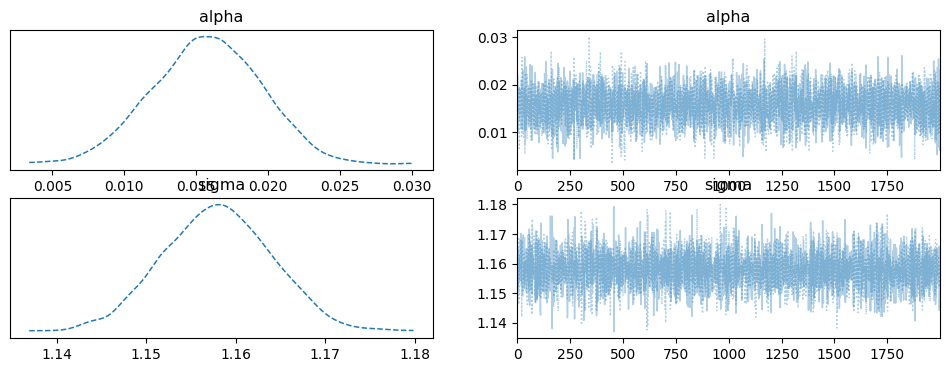

In [ ]:
az.plot_trace(trace, var_names=['alpha','sigma'] ,combined=True)

In [ ]:
az.summary(trace, var_names=['alpha','sigma'] ,round_to=3, stat_funcs={'median': np.median})

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median
alpha,0.019,0.004,0.011,0.026,0.0,0.0,4797.093,3044.537,1.0,0.019
sigma,1.158,0.007,1.145,1.171,0.0,0.0,6543.523,3019.160,1.0,1.158


In [74]:
summary_df = az.summary(trace, round_to=3, stat_funcs={'median': np.median})
summary_df.shape

(310, 10)

In [ ]:
# # if you want to add median or other stats to summary, use  stat_funcs, ex:
# summary_df = az.summary(trace, stat_funcs={'median': np.median})

In [ ]:
'''
Columns in az.summary():

mean: The mean of the posterior samples.
sd: The standard deviation of the posterior samples.
hdi_3% and hdi_97%: The highest density interval (HDI) bounds, which by default represent the 94% HDI. These columns indicate the range within which 94% of the posterior samples fall.
mcse_mean: The Monte Carlo standard error of the mean, which gives an estimate of the error in the mean due to finite sampling.
mcse_sd: The Monte Carlo standard error of the standard deviation.
ess_bulk: The effective sample size for the bulk of the distribution, indicating the number of independent samples that the chain is equivalent to.
ess_tail: The effective sample size for the tails of the distribution.
r_hat: The R-hat statistic, which is a diagnostic measure to assess convergence of the chains. Values close to 1 indicate good convergence.

'''

In [75]:
summary_df.head(5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median
alpha,0.016,0.004,0.009,0.023,0.000,0.000,3255.810,2849.379,1.000,0.016
"beta[0, 0]",-0.040,0.096,-0.218,0.140,0.001,0.001,5515.059,3073.764,1.000,-0.041
"beta[1, 0]",0.115,0.055,0.013,0.218,0.001,0.001,4309.664,3245.797,1.001,0.114
"beta[2, 0]",0.083,0.071,-0.040,0.227,0.001,0.001,4115.564,2990.883,1.000,0.082
"beta[3, 0]",0.056,0.058,-0.048,0.168,0.001,0.001,4524.724,2969.637,1.000,0.056


In [76]:
summary_df.index[-10:]

Index(['beta[299, 0]', 'beta[300, 0]', 'beta[301, 0]', 'beta[302, 0]',
       'beta[303, 0]', 'beta[304, 0]', 'beta[305, 0]', 'beta[306, 0]',
       'beta[307, 0]', 'sigma'],
      dtype='object')

In [77]:
n_features

308

In [ ]:
# save
summary_df.to_csv('pymc_warp_prior_summary_conf_74.csv')

In [ ]:
# look at Players' offense and defense coeffs

In [78]:
offense_summary = summary_df.loc[summary_df.index.str.contains('beta')][:(n_features//2)]
# add player id and player name cols
offense_summary['playerId'] = players
offense_summary = offense_summary.merge(prior_df[['playerId','fullName']], on='playerId', how='left')
offense_summary.shape

(154, 12)

In [79]:
# why not centered closer to 0?
print(summary_df.loc[summary_df.index.str.contains('beta')]['mean'].mean())
print(offense_summary['mean'].mean())

0.07498701298701298
0.07492207792207792


In [80]:
defense_summary = summary_df.loc[summary_df.index.str.contains('beta')][(n_features//2):]
defense_summary['playerId'] = players
defense_summary = defense_summary.merge(prior_df[['playerId','fullName']], on='playerId', how='left')
defense_summary.shape

(154, 12)

In [ ]:
# top offense players # alpha_mu = 0.2 - results seem shuffled around a bit compared to alpha_mu = 0
offense_summary.sort_values(by='mean', ascending=False).head(20).merge(prior_df[['playerId','warp']], on='playerId', how='left')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,playerId,fullName,warp
0,0.274,0.072,0.139,0.409,0.001,0.001,7811.558,2816.781,1.002,0.273,1309579,Keion Brooks Jr.,3.881014
1,0.254,0.065,0.135,0.373,0.001,0.001,7989.108,3433.576,1.000,0.255,1606251,Tristan da Silva,4.087134
2,0.240,0.064,0.115,0.355,0.001,0.001,8013.688,3154.400,1.000,0.240,979279,Jermaine Couisnard,3.940074
3,0.230,0.059,0.115,0.340,0.001,0.000,8159.154,2996.938,1.001,0.231,1912250,Tyler Bilodeau,2.273034
4,0.211,0.068,0.087,0.342,0.001,0.001,7769.553,3214.368,1.000,0.211,1890577,Keba Keita,2.820124
5,0.201,0.061,0.086,0.316,0.001,0.001,6715.305,3203.165,1.000,0.202,1704745,Will McClendon,-0.338956
6,0.200,0.058,0.087,0.305,0.001,0.000,7606.583,2627.783,1.000,0.200,1912256,Michael Rataj,0.613664
7,0.186,0.058,0.077,0.298,0.001,0.001,7526.846,3252.058,1.001,0.185,1600136,Pelle Larsson,2.108384
8,0.181,0.055,0.082,0.288,0.001,0.000,7608.507,3194.721,1.002,0.180,1602614,Brandon Angel,0.508764
9,0.179,0.068,0.055,0.307,0.001,0.001,8002.528,3109.135,1.002,0.179,1602971,Deivon Smith,2.999284


In [81]:
# top offense players # alpha_mu = 0
offense_summary.sort_values(by='mean', ascending=False).head(10).merge(prior_df[['playerId','warp']], on='playerId', how='left')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,playerId,fullName,warp
0,0.246,0.062,0.128,0.363,0.001,0.001,4349.706,3002.534,1.000,0.245,1309579,Keion Brooks Jr.,3.881014
1,0.237,0.062,0.119,0.352,0.001,0.001,4752.361,2766.937,1.000,0.238,979279,Jermaine Couisnard,3.940074
2,0.230,0.059,0.120,0.341,0.001,0.001,4474.337,2523.240,1.001,0.230,1602971,Deivon Smith,2.999284
3,0.199,0.061,0.088,0.318,0.001,0.001,3848.911,3065.651,1.002,0.199,1606251,Tristan da Silva,4.087134
4,0.191,0.057,0.085,0.300,0.001,0.001,4430.517,2593.307,1.001,0.190,1912256,Michael Rataj,0.613664
5,0.189,0.058,0.085,0.298,0.001,0.001,4651.261,3080.109,1.000,0.188,1912250,Tyler Bilodeau,2.273034
6,0.187,0.062,0.066,0.299,0.001,0.001,4238.521,3101.344,1.000,0.187,1600136,Pelle Larsson,2.108384
7,0.184,0.070,0.061,0.327,0.001,0.001,4809.962,2985.044,1.000,0.185,1720265,KJ Simpson,7.522124
8,0.183,0.057,0.077,0.287,0.001,0.001,5105.405,2939.464,1.001,0.183,1602614,Brandon Angel,0.508764
9,0.182,0.059,0.069,0.289,0.001,0.001,4427.552,2694.366,1.001,0.182,1916388,Bryant Selebangue,0.331924


In [ ]:
# top defensive players,  alpha_mu = 0
defense_summary.sort_values(by='mean', ascending=True).head(10).merge(prior_df[['playerId','warp']], on='playerId', how='left')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,playerId,fullName,warp
0,-0.055,0.097,-0.236,0.128,0.001,0.002,8449.097,2870.768,1.001,-0.054,1587723,Gabe Reichle,-1.213746
1,-0.038,0.054,-0.142,0.061,0.001,0.001,7358.656,3289.713,1.000,-0.038,1920157,Jaden Bradley,-0.440956
2,-0.019,0.060,-0.131,0.094,0.001,0.001,6759.612,3899.243,1.000,-0.020,1720267,Lawson Lovering,-0.702206
3,-0.019,0.094,-0.204,0.148,0.001,0.002,7587.557,2179.538,1.003,-0.020,1761457,James Cooper,-1.185986
4,-0.016,0.101,-0.198,0.174,0.001,0.002,6970.983,2576.075,1.001,-0.016,1912254,Felipe Palazzo,-1.102856
5,-0.015,0.098,-0.205,0.157,0.001,0.002,9238.270,3148.245,1.000,-0.018,1605345,Logan Cremonesi,-1.117436
6,-0.013,0.097,-0.184,0.183,0.001,0.002,9007.240,3105.180,1.002,-0.012,1720274,Jack Pease,-1.078566
7,-0.011,0.100,-0.209,0.171,0.001,0.002,8700.649,2672.092,1.000,-0.009,1907393,AJ Rohosy,-1.034416
8,-0.011,0.061,-0.125,0.102,0.001,0.001,7427.075,3157.386,1.000,-0.012,1614984,Braxton Meah,0.021904
9,-0.010,0.093,-0.181,0.168,0.001,0.002,8542.407,2916.603,1.000,-0.010,1336051,Brandon Haddock,-1.045226


In [ ]:
# top defensive players,  alpha_mu = 0.2
defense_summary.sort_values(by='mean', ascending=True).head(10).merge(prior_df[['playerId','warp']], on='playerId', how='left')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,playerId,fullName,warp
0,-0.060,0.057,-0.166,0.046,0.001,0.001,7270.433,3448.728,1.001,-0.060,1920157,Jaden Bradley,-0.440956
1,-0.056,0.099,-0.239,0.129,0.001,0.001,8122.098,2963.124,1.001,-0.056,1587723,Gabe Reichle,-1.213746
2,-0.036,0.073,-0.175,0.093,0.001,0.001,6586.655,3226.750,1.000,-0.037,2139331,Bangot Dak,-1.099536
3,-0.023,0.101,-0.214,0.156,0.001,0.002,7076.111,2688.680,1.003,-0.023,1945377,Sam Slutske,-1.136236
4,-0.022,0.098,-0.209,0.155,0.001,0.002,6985.508,2953.906,1.001,-0.023,2106224,Devin Williams,-0.997416
5,-0.022,0.098,-0.199,0.166,0.001,0.002,7745.005,2917.111,1.001,-0.022,1964766,Nehemie Kabeya,-1.108466
6,-0.021,0.100,-0.223,0.153,0.001,0.002,6746.661,2842.033,1.002,-0.019,1912254,Felipe Palazzo,-1.102856
7,-0.020,0.099,-0.204,0.169,0.001,0.002,8643.023,3058.135,1.000,-0.020,2125364,Will Landram,-1.128566
8,-0.019,0.100,-0.207,0.161,0.001,0.002,8835.781,2568.352,1.000,-0.020,1720274,Jack Pease,-1.078566
9,-0.018,0.095,-0.201,0.157,0.001,0.002,6698.411,2489.712,1.002,-0.018,1761457,James Cooper,-1.185986


In [ ]:
# Attempts with AESARA (instead of pytensor) - None Worked xx

In [ ]:
# %%time

# # Define the bayesian model using PyMC
# with pm.Model() as model:
#     # Priors for unknown model parameters
#     warp_priors = np.array(list(warp_prior['warp'])*2)
#     alpha = pm.Normal("alpha", mu=0, sigma=1)  # TODO- what mean and sigma to choose here?
#     beta = pm.Normal("beta", mu=alpha*warp_priors, sigma=0.1, shape=n_features)  # sigma arg here represents standard dev., not variance
#     sigma = pm.HalfNormal("sigma", sigma=1)

#     # # Likelihood (sampling distribution) of observations
#     # mu = pm.math.dot(X_sparse, beta)
#     mu = sparse.basic.dot(X_sparse_aesara, beta)
#     Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y_obs)

#     # Make beta a deterministic node to ensure it's an Aesara variable
#     #beta_tensor = pm.Deterministic("beta_tensor", beta)
#     # beta_tensor = at.as_tensor_variable(beta)

#     # Sample from the posterior distribution
#     trace = pm.sample(2000, tune=1000)

In [ ]:
# %%time

# # Define custom log-likelihood function
# def custom_loglike(y, X, beta, sigma):
#     # Ensure beta is treated as an Aesara variable
#     #beta = at.as_tensor_variable(beta)
#     mu = sparse.dot(X, beta)
#     return pm.Normal.dist(mu=mu, sigma=sigma).logp(y)


# # Define the bayesian model using PyMC
# with pm.Model() as model:
#     # Priors for unknown model parameters
#     warp_priors = np.array(list(warp_prior['warp'])*2)
#     alpha = pm.Normal("alpha", mu=0, sigma=1)  # TODO- what mean and sigma to choose here?
#     beta = pm.Normal("beta", mu=alpha*warp_priors, sigma=0.1, shape=n_features)  # sigma arg here represents standard dev., not variance
#     sigma = pm.HalfNormal("sigma", sigma=1)

#     # # Likelihood (sampling distribution) of observations
#     # mu = pm.math.dot(X_sparse, beta)
#     # Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y_obs)

#     # Make beta a deterministic node to ensure it's an Aesara variable
#     #beta_tensor = pm.Deterministic("beta_tensor", beta)
#     beta_tensor = at.as_tensor_variable(beta)

#     # Custom log-likelihood
#     pm.Potential("loglike", custom_loglike(y_obs, X_sparse_aesara, beta_tensor, sigma))

#     # Sample from the posterior distribution
#     trace = pm.sample(2000, tune=1000)

In [ ]:
#https://betanalpha.github.io/assets/case_studies/qr_regression.html


In [ ]:
# official pymc github - https://github.com/pymc-devs/pymc

In [ ]:
# import numpy as np
# import scipy.sparse as sp
# import aesara
# import aesara.tensor as at
# import aesara.sparse as sparse
# from aesara.graph.op import Op
# from aesara.graph.basic import Apply

# class SparseDotOp(Op):
#     __props__ = ()

#     def make_node(self, X, beta):
#         X = aesara.sparse.as_sparse_variable(X)
#         beta = at.as_tensor_variable(beta)
#         output = at.dot(X, beta)
#         return Apply(self, [X, beta], [output.type()])

#     def perform(self, node, inputs, outputs):
#         X, beta = inputs
#         z = outputs[0]
#         z[0] = X.dot(beta)

# sparse_dot = SparseDotOp()


# import arviz as az

# # Define the model using PyMC
# with pm.Model() as model:
#     # Priors for unknown model parameters
#     warp_priors = np.array(list(warp_prior['warp'])*2)
#     alpha = pm.Normal("alpha", mu=0, sigma=1)
#     beta = pm.Normal("beta", mu=alpha * warp_priors, sigma=0.1, shape=n_features)
#     sigma = pm.HalfNormal("sigma", sigma=1)

#     # Custom log-likelihood using the custom Op
#     mu = sparse_dot(X_sparse_aesara, beta)
#     y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

#     # Sample from the posterior distribution
#     trace = pm.sample(2000, tune=1000, target_accept=0.95)

# # Trace plots to visualize the posterior distributions
# az.plot_trace(trace)
# plt.show()

# # Summary statistics of the posterior distribution
# print(az.summary(trace))



## Trying QR decomposition

In [ ]:
# GAVE UP ON THIS - the code works fine now but beta values are all wacky when converted to original beta.
# maybe cuz R_train matrix is very unstable as we have a bunch of binary columns

In [ ]:
# seems like a good method to stabilize the coeffs and alleviate the correlation problem

# paper - https://betanalpha.github.io/assets/case_studies/qr_regression.html

In [ ]:
import sparseqr

In [ ]:
def sparseqr_reduced_qr_decomposition(X):
    Q_full, R_full, perm_vector, _ = sparseqr.qr(X)  # Perform full QR decomposition
    Q_reduced = Q_full.tocsr()[:, :X.shape[1]]  # Extract first m columns
    R_reduced = R_full.tocsr()[:X.shape[1], :]  # Extract first m rows
    return sp.csr_matrix(Q_reduced), sp.csr_matrix(R_reduced), perm_vector

In [ ]:
# example
M = sp.random(10, 5, density=0.1, format='csr')
# mean = M.mean(axis=0)
# M = M - mean -- needed to center?
Q,R, E = sparseqr_reduced_qr_decomposition(M)
M.toarray()

array([[0.        , 0.96985555, 0.94433379, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.41900507],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.89861159, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.7999078 ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

In [ ]:
# checking if q * r * p.t == M as it should
P= sparseqr.permutation_vector_to_matrix(E).tocsr()
(Q @ R @ P.T).toarray()

array([[0.        , 0.96985555, 0.94433379, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.41900507],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.89861159, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.7999078 ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

In [ ]:
%%time

# Using 4-fold cross validation for evaluation

import pymc as pm
import numpy as np
import pytensor
import pytensor.tensor as pt
import pytensor.sparse as sparse
import scipy.sparse as sp

kf = KFold(n_splits=4)
mse_values = []

warp_priors = np.array(list(prior_df['warp'])*2).reshape((n_features,1))

# Define the bayesian model using PyMC
for train_index, test_index in kf.split(X_sparse):
  X_train_sparse, X_test_sparse = X_sparse[train_index], X_sparse[test_index]
  y_train, y_test = y_obs[train_index], y_obs[test_index]

  # Perform QR decomposition on X_train
  Q_train, R_train, E_train = sparseqr_reduced_qr_decomposition(X_train_sparse)
  P_train = sparseqr.permutation_vector_to_matrix(E_train).tocsr()

  warp_priors_new = R_train @ P_train.T @ warp_priors
  print('priors shape', warp_priors_new.shape)

  with pm.Model() as model:
    # Define priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=1)  # TODO- what mean and sigma to choose here?
    beta_prime_mu = alpha * warp_priors_new
    beta_prime = pm.Normal("beta_prime", mu=beta_prime_mu, sigma=0.1, shape=(R_train.shape[0],1))  # sigma arg here represents standard dev., not variance
    sigma = pm.HalfNormal("sigma", sigma=1)

    # # TOTRY in future - adding regularization to beta directly
    # # Regularization term directly on beta
    # lambda_ = pm.HalfCauchy('lambda_', beta=1)
    # pm.Potential('ridge', -0.5 * lambda_ * pm.math.sum(beta_prime ** 2))

    # print statements for debug
    # print(Q_train.shape)
    # print(R_train.shape)
    # print(P_train.shape)
    # print(beta_prime_mu.shape)
    # shape = pt.shape(beta_prime)
    # shape_fn = pytensor.function([], shape)
    # print("Shape of beta prime:", shape_fn())
    # print(beta_prime.type)

    print('dot product')
    Q_train_sparse_pt = sparse.as_sparse_variable(Q_train)
    mu = sparse.basic.structured_dot(Q_train_sparse_pt, beta_prime).flatten()

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y_train)
    print('likelihood defined')

    # Variational Inference - faster than mcmc sampling because it does approximations., but less accurate as a result
    # It's a MUST - otherwise it will take forever to run with pm.sample()
    approx = pm.fit(method='advi', n=2000) # n = nr of approx iterations, increases it later

    # Sample from the posterior
    trace = approx.sample(1000)

    # Perform QR on X_test
    Q_test, _, E_test = sparseqr_reduced_qr_decomposition(X_test_sparse)

    # Make predictions on the test set
    posterior_predictive = pm.sample_posterior_predictive(trace, var_names=["beta_prime"])
    beta_prime_samples = posterior_predictive.posterior_predictive["beta_prime"].mean(axis=0).squeeze()
    y_pred_samples = Q_test @ beta_prime_samples.T
    y_pred = y_pred_samples.mean(axis=1)

    # Evaluate the model
    mse = mean_squared_error(y_pred, y_test)
    mse_values.append(mse)
    print(f"MSE: {mse:.2f}")


priors shape (308, 1)
(13606, 308)
(308, 308)
(308, 308)
Shape.0
Shape of beta prime: [308   1]
Matrix(float64, shape=(308, 1))
dot product
likelihood defined


MSE: 2.48
priors shape (308, 1)
(13606, 308)
(308, 308)
(308, 308)
Shape.0
Shape of beta prime: [308   1]
Matrix(float64, shape=(308, 1))
dot product
likelihood defined


MSE: 2.92
priors shape (308, 1)
(13607, 308)
(308, 308)
(308, 308)
Shape.0
Shape of beta prime: [308   1]
Matrix(float64, shape=(308, 1))
dot product
likelihood defined


MSE: 2.84
priors shape (308, 1)
(13607, 308)
(308, 308)
(308, 308)
Shape.0
Shape of beta prime: [308   1]
Matrix(float64, shape=(308, 1))
dot product
likelihood defined


MSE: 3.57
CPU times: user 24min 16s, sys: 3min 4s, total: 27min 21s
Wall time: 19min 11s


In [ ]:
np.mean(mse_values)

2.952770930438538

In [ ]:
# Convert beta_prime to original beta

import scipy.linalg as la
import scipy.sparse.linalg as spla

# Extract the sampled beta_prime from the trace
beta_prime_samples = trace.posterior['beta_prime'].values.squeeze()
print(beta_prime_samples.shape)

# Number of samples and number of features
nr_samples = beta_prime_samples.shape[0]
nr_features = R_train.shape[1]
print(nr_samples, nr_features)

# Initialize array to store the original beta samples
beta_samples = np.zeros((nr_samples, nr_features))

def regularize_matrix(R, epsilon=1e-10):
    """
    Add a small value to the diagonal of R to make it invertible.
    """
    R_reg = R.copy()
    diag_indices = np.diag_indices(min(R.shape))
    R_reg[diag_indices] += epsilon
    return R_reg

# Regularize R_train
R_train_reg = regularize_matrix(R_train)

for i in range(nr_samples):
    # Solve for beta in equation: R * beta = beta_prime for each sample, without inverting R.
    # This is efficient since R is upper triangular
    #beta_samples[i] = la.solve_triangular(R_train, beta_prime_samples[i], lower=False)

    # use sparse solver to solve for beta so you dont need to invert R, eqn -> R_train.dot(P_train.T).dot(Beta) = bETA_prime
    beta_samples[i] = spla.spsolve(R_train_reg.dot(P_train.T), beta_prime_samples[i])

(1000, 308)
1000 308


In [ ]:
R_train_reg = regularize_matrix(R_train, 0.1)
for i in range(nr_samples):
    # use sparse solver to solve for beta so you dont need to invert R, eqn -> R_train.dot(P_train.T).dot(Beta) = bETA_prime
    beta_samples[i] = P_train @ np.linalg.inv(R_train_reg.toarray()) @ beta_prime_samples[i]

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
R_train_reg = regularize_matrix(R_train, 0.01)
for i in range(nr_samples):
  beta_samples[i] =spla.lsqr(R_train_reg.dot(P_train.T), beta_prime_samples[i])[0]


/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
beta_samples.shape

(1000, 308)

In [ ]:
# Convert beta_samples to a Pandas DataFrame or an InferenceData object if needed
# beta_df = pd.DataFrame(beta_samples, columns=[f'beta_{i}' for i in range(nr_features)])
# print(beta_df.describe())

beta_df = pd.DataFrame({'mean':beta_samples.mean(axis=0)})

offense_summary = beta_df[:(n_features//2)]
offense_summary['playerId'] = players
offense_summary = offense_summary.merge(prior_df[['playerId','fullName','warp']], on='playerId', how='left')
offense_summary.shape

<ipython-input-115-85d3d3a71c76>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offense_summary['playerId'] = players


(154, 4)

In [ ]:
defense_summary = beta_df[(n_features//2):]
defense_summary['playerId'] = players
defense_summary = defense_summary.merge(prior_df[['playerId','fullName', 'warp']], on='playerId', how='left')
defense_summary.shape

<ipython-input-116-6aa4fc2c0604>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defense_summary['playerId'] = players


(154, 4)

In [ ]:
offense_summary.head()

,mean,playerId,fullName,warp
0,-5.678982e+07,1587723,Gabe Reichle,-1.213746
1,-5.678982e+07,1330700,Spencer Jones,2.116074
2,-5.678982e+07,1330703,James Keefe,-1.248526
3,-5.678982e+07,1310230,Dexter Akanno,-0.875886
4,-5.678982e+07,1948694,Nate Calmese,-1.065816


In [ ]:
offense_summary['mean'][0]

-0.016633131533355543

## Fit Bayesian model with Ortg/Drtg priors


In [133]:
X_sparse = sparse_matrix_csr
y_obs = poss_df['ptsScored']
print(np.mean(y_obs>0))

0.488810494984015


In [134]:
print(y_obs.shape)
print(y_obs.dtype)

(18142,)
Int64


In [135]:
n_samples = len(poss_df)
n_features = X_sparse.shape[1]

In [136]:
X_sparse.shape

(18142, 308)

In [137]:
n_samples,n_features

(18142, 308)

In [138]:
# Player (beta) priors
off_def_priors = np.array(pd.concat([prior_df['ortgPlayer'],prior_df['drtgPlayer']])).reshape((n_features,1))
off_def_priors.shape

(308, 1)

### Fit Normal Model

In [ ]:
%%time

# Using 4-fold cross validation for evaluation

import pymc as pm
import numpy as np
import pytensor
import pytensor.tensor as pt
import pytensor.sparse as sparse
import scipy.sparse as sp

kf = KFold(n_splits=4)
mse_values = []

# Define the bayesian model using PyMC
for train_index, test_index in kf.split(X_sparse):
  X_train_sparse, X_test_sparse = X_sparse[train_index], X_sparse[test_index]
  y_train, y_test = y_obs[train_index], y_obs[test_index]

  with pm.Model() as model:
    # Define priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=1)  # TODO- what mean and sigma to choose here?
    beta = pm.Normal("beta", mu=alpha * off_def_priors, sigma=0.1, shape=(n_features,1))  # sigma arg here represents standard dev., not variance
    #beta = pm.Normal("beta", mu=off_def_priors, sigma=0.1, shape=(n_features,1)) # this lowered mse from 2.42 to 2.32!!!!
    sigma = pm.HalfNormal("sigma", sigma=1)

    # some print statements for debugging
    # shape = pt.shape(beta)
    # shape_fn = pytensor.function([], shape)
    # print("Shape of beta:", shape_fn())
    # print(beta.type)

    print('dot product')
    X_train_sparse_pt = sparse.as_sparse_variable(X_train_sparse)
    mu = sparse.basic.structured_dot(X_train_sparse_pt, beta).flatten()
    # mu = pm.math.dot(X_sparse, beta)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y_train)
    print('likelihood defined')

    # Sample from the posterior distribution
    trace = pm.sample(2000, return_inferencedata=True) #tune = 500 --tuning steps

    # Make predictions on the test set
    print('evaluating the  model')
    beta=trace.posterior['beta'].values.squeeze(axis=-1)
    beta=np.vstack(beta)
    beta_hat = beta.mean(axis=0)
    print(beta_hat.shape)
    y_pred = X_test_sparse @ beta_hat
    y_pred_mean = np.mean(y_pred)
    print('mean prediction', y_pred_mean)

    # Evaluate the model
    mse = mean_squared_error(y_pred, y_test)
    mae = mean_absolute_error(y_pred, y_test)
    mse_values.append(mse)
    print(f"MSE: {mse:.2f}")
    print(f"MAE: {mae:.2f}")
    print('binary classification error', 1-accuracy_score(y_pred>y_pred_mean, y_test>0)) # predict 1 pts_scored when y_pred >y_pred_mean
    print('overall classification error',1-accuracy_score(np.round(y_pred), y_test))


In [ ]:
# # average mse
# np.mean(mse_values)

In [139]:
%%time

# 1-fold validation

import pymc as pm
import numpy as np
import pytensor
import pytensor.tensor as pt
import pytensor.sparse as sparse
import scipy.sparse as sp


# Define the bayesian model using PyMC
train_size = int(0.8 * n_samples)
X_train_sparse, X_test_sparse = X_sparse[:train_size], X_sparse[train_size:]
y_train, y_test = y_obs[:train_size], y_obs[train_size:]

with pm.Model() as model:
  # Define priors for unknown model parameters
  alpha = pm.Normal("alpha", mu=0, sigma=1)  # TODO- what mean and sigma to choose here?
  beta = pm.Normal("beta", mu=alpha * off_def_priors, sigma=0.1, shape=(n_features,1))  # sigma arg here represents standard dev., not variance
  sigma = pm.HalfNormal("sigma", sigma=1)

  print('dot product')
  X_train_sparse_pt = sparse.as_sparse_variable(X_train_sparse)
  mu = sparse.basic.structured_dot(X_train_sparse_pt, beta).flatten()

  # Likelihood (sampling distribution) of observations
  Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y_train)
  print('likelihood defined')

  # Sample from the posterior distribution
  trace = pm.sample(2000, return_inferencedata=True) #tune = 500 --tuning steps

  # Make predictions on the test set
  print('evaluating the  model')
  beta=trace.posterior['beta'].values.squeeze(axis=-1)
  beta=np.vstack(beta)
  beta_hat = beta.mean(axis=0)
  print(beta_hat.shape)
  y_pred = X_test_sparse @ beta_hat
  y_pred_mean = np.mean(y_pred)
  print('mean prediction', y_pred_mean)

  # Evaluate the model
  mse = mean_squared_error(y_pred, y_test)
  mae = mean_absolute_error(y_pred, y_test)
  print(f"MSE: {mse:.2f}")
  print(f"MAE: {mae:.2f}")
  #print('binary classification error 1', 1-accuracy_score(np.round(y_pred)>0, y_test>0)) # no sense since all y_pred are >0
  print('binary classification error', 1-accuracy_score(y_pred>y_pred_mean, y_test>0)) # predict 1 pts_scored when y_pred >y_pred_mean
  print('overall classification error',1-accuracy_score(np.round(y_pred), y_test))


dot product
likelihood defined


evaluating the  model
(308,)
mean prediction 1.053876422369491
MSE: 1.34
MAE: 1.09
binary classification error 0.4794709286304767
overall classification error 0.9583907412510333
CPU times: user 3min 6s, sys: 1.18 s, total: 3min 7s
Wall time: 3min 12s


In [ ]:
# **NOTE: when we change alpha_mu from 0 to 1, mse lowers to 2.27 but MAE increases to 1.15!!!


In [78]:
np.sum(np.round(y_pred)), len(y_pred)

(3624.0, 3629)

In [79]:
np.mean(y_test>0)

0.4888399007991182

<Axes: ylabel='Count'>

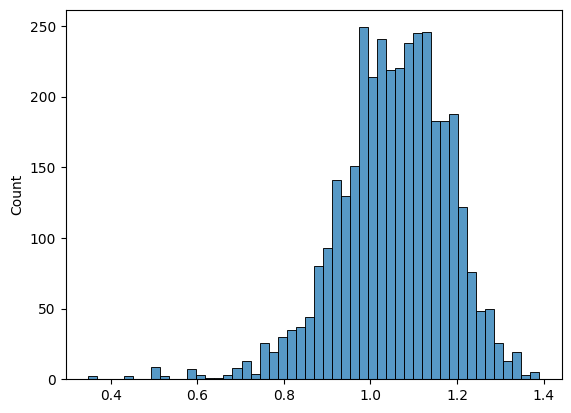

In [80]:
import seaborn as sns
sns.histplot(y_pred)

<Axes: ylabel='Count'>

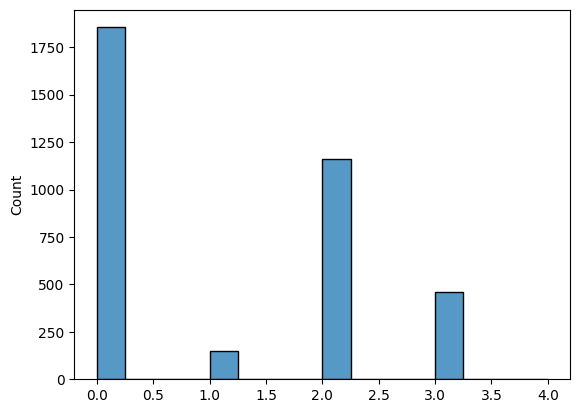

In [81]:
sns.histplot(np.array(y_test))

In [82]:
np.max(y_pred), np.min(y_pred)

(1.3898069122663583, 0.34795644089079714)

In [83]:
np.sum(np.round(y_pred)) # almost all preds = 1 when rounded

3624.0

In [62]:
#another metric
y_pred[(y_test==0).astype(int)].mean(), y_pred[(y_test==1).astype(int)].mean(), y_pred[(y_test>1).astype(int)].mean()

(0.930462280608415, 0.9434111090742338, 0.9322252666436673)

In [63]:
# Compute mse/mae at stint level
stint_m = compute_stint_metrics(poss_df[train_size:], y_pred)

MSE: 3.61
MAE: 1.50
binary classification error 0.4196363636363636


#### Analyze Pymc results

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

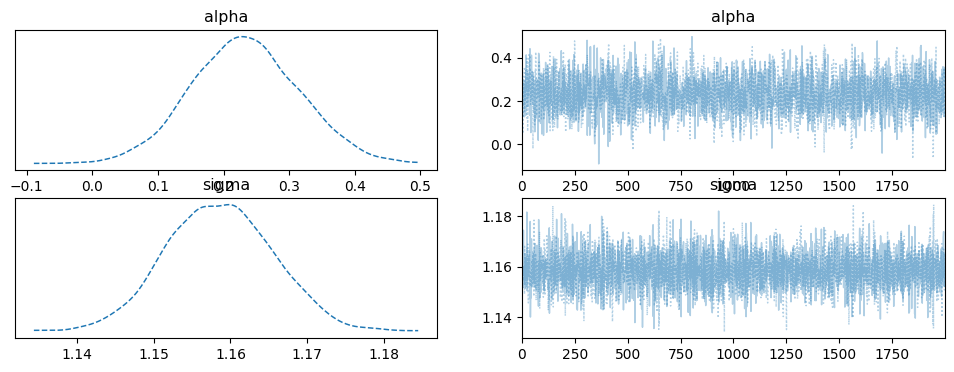

In [ ]:
az.plot_trace(trace, var_names=['alpha','sigma'] ,combined=True)

In [140]:
summary_df = az.summary(trace, round_to=3, stat_funcs={'median': np.median})
summary_df.shape

(310, 10)

In [ ]:
# # save
# summary_df.to_csv('pymc_off_def_prior_summary_conf_74.csv')

In [141]:
offense_summary = summary_df.loc[summary_df.index.str.contains('beta')][:(n_features//2)]
# add player id and player name cols
offense_summary['playerId'] = players
offense_summary = offense_summary.merge(prior_df[['playerId','fullName','ortgPlayer','warp']], on='playerId', how='left')
offense_summary.shape

(154, 14)

In [142]:
# why not centered closer to 0?
print(summary_df.loc[summary_df.index.str.contains('beta')]['mean'].mean())
print(offense_summary['mean'].mean())

0.07565259740259742
0.07183116883116884


In [143]:
defense_summary = summary_df.loc[summary_df.index.str.contains('beta')][(n_features//2):]
defense_summary['playerId'] = players
defense_summary = defense_summary.merge(prior_df[['playerId','fullName','drtgPlayer']], on='playerId', how='left')
defense_summary.shape

(154, 13)

In [ ]:
# # top offensive players
# offense_summary.sort_values(by='mean', ascending=False).head(10) # with alpha_mu = 1 instead of 0

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,playerId,fullName,ortgPlayer,warp
116,0.235,0.062,0.126,0.354,0.001,0.001,5926.551,3595.172,1.000,0.235,1309579,Keion Brooks Jr.,0.112560,3.881014
123,0.227,0.059,0.118,0.337,0.001,0.001,5203.053,3289.669,1.000,0.229,1602971,Deivon Smith,0.065275,2.999284
102,0.220,0.060,0.103,0.328,0.001,0.001,5814.045,3100.879,1.000,0.222,979279,Jermaine Couisnard,0.039387,3.940074
41,0.202,0.117,-0.022,0.416,0.002,0.001,3713.512,2922.945,1.000,0.202,1969817,Roy Yuan,0.791532,-1.024356
35,0.201,0.063,0.089,0.321,0.001,0.001,4642.822,3287.997,1.000,0.201,1600136,Pelle Larsson,0.164481,2.108384
18,0.198,0.058,0.088,0.306,0.001,0.001,5777.670,3018.191,1.000,0.197,1602614,Brandon Angel,0.139504,0.508764
149,0.193,0.060,0.089,0.313,0.001,0.001,5391.325,3262.940,1.000,0.193,1916388,Bryant Selebangue,0.102655,0.331924
25,0.192,0.060,0.073,0.300,0.001,0.001,5084.907,3162.016,1.001,0.192,1606251,Tristan da Silva,0.128103,4.087134
131,0.190,0.058,0.079,0.297,0.001,0.001,6325.634,3162.283,1.001,0.190,1912250,Tyler Bilodeau,0.110706,2.273034
135,0.187,0.058,0.077,0.298,0.001,0.001,6289.963,2971.537,1.000,0.187,1912256,Michael Rataj,-0.021447,0.613664


In [ ]:
# top offensive players
offense_summary.sort_values(by='mean', ascending=False).head(20) # seems close to warp prior resu
# but definitely affected by the new prior as well

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,playerId,fullName,ortgPlayer,warp
116,0.236,0.063,0.119,0.353,0.001,0.001,4877.277,3097.802,1.001,0.235,1309579,Keion Brooks Jr.,0.112560,3.881014
123,0.227,0.060,0.111,0.342,0.001,0.001,5106.675,2770.752,1.001,0.227,1602971,Deivon Smith,0.065275,2.999284
102,0.221,0.060,0.105,0.332,0.001,0.001,5186.585,2869.272,1.000,0.221,979279,Jermaine Couisnard,0.039387,3.940074
35,0.202,0.061,0.085,0.312,0.001,0.001,5119.809,2816.041,1.000,0.202,1600136,Pelle Larsson,0.164481,2.108384
18,0.197,0.059,0.085,0.305,0.001,0.001,4396.643,2957.387,1.000,0.198,1602614,Brandon Angel,0.139504,0.508764
41,0.196,0.118,-0.020,0.420,0.002,0.001,3747.580,3012.938,1.000,0.194,1969817,Roy Yuan,0.791532,-1.024356
149,0.194,0.060,0.079,0.305,0.001,0.001,4804.340,2871.987,1.000,0.193,1916388,Bryant Selebangue,0.102655,0.331924
25,0.192,0.061,0.078,0.309,0.001,0.001,5318.673,2962.283,1.000,0.193,1606251,Tristan da Silva,0.128103,4.087134
131,0.190,0.060,0.076,0.301,0.001,0.001,5295.119,3094.484,1.000,0.190,1912250,Tyler Bilodeau,0.110706,2.273034
135,0.188,0.058,0.076,0.298,0.001,0.001,5237.186,3209.096,1.000,0.189,1912256,Michael Rataj,-0.021447,0.613664


In [ ]:
prior_df.sort_values(by='ortgPlayer', ascending=False).head(10)

,playerId,warp,fullName,ortgPlayer,drtgPlayer,player_mins
41,1969817,-1.024356,Roy Yuan,0.791532,0.123325,6.14
38,2126483,0.399514,Josiah Lake II,0.329849,0.005892,447.27
5,1600029,2.769314,J'Vonne Hadley,0.232922,-0.015677,1232.03
77,1731840,3.187024,Jaylen Wells,0.212283,-0.012864,992.63
142,1720265,7.522124,KJ Simpson,0.182693,-0.031662,1298.14
129,1309612,5.451164,Oumar Ballo,0.174874,-0.129774,935.64
101,1309512,4.508324,N'Faly Dante,0.165621,-0.078220,692.11
35,1600136,2.108384,Pelle Larsson,0.164481,-0.042520,1083.23
137,1589696,-0.849666,Grant Weitman,0.163354,-0.164725,40.73
90,2098978,0.802564,Motiejus Krivas,0.160263,-0.103281,437.10


In [ ]:
# top defensive players
defense_summary.sort_values(by='mean', ascending=True).head(20)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,playerId,fullName,drtgPlayer
47,-0.078,0.103,-0.275,0.114,0.001,0.001,4909.976,3024.265,1.000,-0.078,1908908,Jack McCloskey,-0.404709
147,-0.064,0.100,-0.249,0.124,0.001,0.001,4912.295,2972.580,1.000,-0.064,1720274,Jack Pease,-0.290177
42,-0.035,0.098,-0.219,0.144,0.001,0.001,5186.854,2911.092,1.000,-0.037,1969818,Josue Gil-Silva,-0.238555
44,-0.029,0.058,-0.137,0.078,0.001,0.001,5264.473,2901.967,1.002,-0.029,1920157,Jaden Bradley,-0.065765
36,-0.013,0.065,-0.141,0.101,0.001,0.001,4940.455,3094.585,1.001,-0.012,1614984,Braxton Meah,-0.032421
51,-0.012,0.100,-0.191,0.178,0.001,0.002,5119.956,2988.832,1.001,-0.012,1907393,AJ Rohosy,-0.077215
144,-0.010,0.065,-0.134,0.110,0.001,0.001,5276.216,2990.960,1.000,-0.011,1720267,Lawson Lovering,-0.037821
0,-0.004,0.099,-0.194,0.176,0.001,0.002,5528.500,2619.217,1.001,-0.004,1587723,Gabe Reichle,0.120493
101,-0.001,0.060,-0.110,0.113,0.001,0.001,4743.164,3009.098,1.001,-0.001,1309512,N'Faly Dante,-0.078220
110,0.002,0.093,-0.173,0.178,0.001,0.002,5588.580,2785.812,1.000,0.000,2106224,Devin Williams,0.021417


In [ ]:
prior_df.sort_values(by='drtgPlayer', ascending=True).head(10)

,playerId,warp,fullName,ortgPlayer,drtgPlayer,player_mins
47,1908908,-1.061076,Jack McCloskey,-0.222355,-0.404709,3.10
147,1720274,-1.078566,Jack Pease,-0.222355,-0.290177,2.03
42,1969818,-1.073376,Josue Gil-Silva,-0.222355,-0.238555,4.80
137,1589696,-0.849666,Grant Weitman,0.163354,-0.164725,40.73
129,1309612,5.451164,Oumar Ballo,0.174874,-0.129774,935.64
57,2093257,1.256414,Rueben Chinyelu,0.017673,-0.117027,483.43
81,1890577,2.820124,Keba Keita,0.126309,-0.105816,567.10
90,2098978,0.802564,Motiejus Krivas,0.160263,-0.103281,437.10
94,2098983,-0.901246,Conrad Martinez,0.073185,-0.098369,69.15
16,1898036,3.776864,Adem Bona,0.025613,-0.092994,852.34


In [146]:
# Top defensive players WITH high mins !!

#identify high min players
max_players_mins = prior_df.player_mins.max()
player_min_thresh = 0.15 * max_players_mins # setting it to 15% of max mins currently
print(max_players_mins, player_min_thresh)
player_w_mins_prior_df = prior_df[prior_df.player_mins > player_min_thresh]
players_with_mins = list(player_w_mins_prior_df.playerId)

defense_summary[defense_summary.playerId.isin(players_with_mins)].sort_values(by='mean', ascending=True).head(20)

1298.14 194.721


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,playerId,fullName,drtgPlayer
44,-0.028,0.058,-0.132,0.083,0.001,0.001,5362.494,3080.323,1.001,-0.028,1920157,Jaden Bradley,-0.065765
36,-0.014,0.065,-0.135,0.104,0.001,0.001,4971.898,3000.459,1.000,-0.013,1614984,Braxton Meah,-0.032421
144,-0.012,0.066,-0.132,0.116,0.001,0.001,5050.507,3259.905,1.000,-0.012,1720267,Lawson Lovering,-0.037821
101,-0.003,0.058,-0.109,0.110,0.001,0.001,5124.827,3284.420,1.000,-0.002,1309512,N'Faly Dante,-0.078220
34,0.004,0.062,-0.114,0.115,0.001,0.001,5741.084,2784.596,1.000,0.004,1696901,Jaylon Tyson,0.027262
135,0.010,0.058,-0.104,0.116,0.001,0.001,5546.307,3173.652,1.000,0.010,1912256,Michael Rataj,0.011414
79,0.016,0.068,-0.109,0.149,0.001,0.001,5758.510,2954.943,1.000,0.015,1329924,Mahamadou Diawara,-0.004131
16,0.018,0.065,-0.104,0.142,0.001,0.001,4544.007,3187.923,1.000,0.018,1898036,Adem Bona,-0.092994
132,0.019,0.059,-0.095,0.129,0.001,0.001,5698.588,3215.140,1.000,0.018,1912252,KC Ibekwe,-0.005580
7,0.020,0.054,-0.080,0.122,0.001,0.001,5691.775,3057.325,1.001,0.021,2112552,Kwame Evans Jr.,-0.049572


In [148]:
# Top offensive players WITH high mins !!
offense_summary[offense_summary.playerId.isin(players_with_mins)].sort_values(by='mean', ascending=False).head(10)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,playerId,fullName,ortgPlayer,warp
116,0.234,0.063,0.119,0.353,0.001,0.001,5432.362,2910.930,1.000,0.234,1309579,Keion Brooks Jr.,0.112560,3.881014
123,0.227,0.060,0.114,0.336,0.001,0.001,5117.874,2962.457,1.000,0.227,1602971,Deivon Smith,0.065275,2.999284
102,0.221,0.061,0.105,0.333,0.001,0.001,5434.044,3036.899,1.000,0.222,979279,Jermaine Couisnard,0.039387,3.940074
35,0.200,0.063,0.076,0.310,0.001,0.001,5603.016,3288.125,1.000,0.200,1600136,Pelle Larsson,0.164481,2.108384
18,0.199,0.058,0.098,0.314,0.001,0.001,5789.807,2932.438,1.001,0.199,1602614,Brandon Angel,0.139504,0.508764
149,0.195,0.062,0.083,0.312,0.001,0.001,5651.746,2881.249,1.001,0.195,1916388,Bryant Selebangue,0.102655,0.331924
25,0.194,0.059,0.091,0.317,0.001,0.001,5611.546,3179.177,1.000,0.193,1606251,Tristan da Silva,0.128103,4.087134
131,0.190,0.058,0.088,0.303,0.001,0.001,5613.430,2852.136,1.000,0.189,1912250,Tyler Bilodeau,0.110706,2.273034
135,0.189,0.059,0.076,0.294,0.001,0.001,5315.685,3093.551,1.000,0.189,1912256,Michael Rataj,-0.021447,0.613664
84,0.186,0.062,0.067,0.300,0.001,0.001,5870.849,2676.139,1.000,0.188,1331990,Jalen Cone,-0.001307,-0.648906


### Fit Poisson Model

In [85]:
%%time

# 1-fold validation , with Poisson distribution!

import pymc as pm
import numpy as np
import pytensor
import pytensor.tensor as pt
import pytensor.sparse as sparse
import scipy.sparse as sp


# Define the bayesian model using PyMC
train_size = int(0.8 * n_samples)
X_train_sparse, X_test_sparse = X_sparse[:train_size], X_sparse[train_size:]
y_train, y_test = y_obs[:train_size], y_obs[train_size:]

with pm.Model() as model:
  # Define priors for unknown model parameters
  alpha = pm.Normal("alpha", mu=0, sigma=1)  # TODO- what mean and sigma to choose here?
  beta = pm.Normal("beta", mu=alpha * off_def_priors, sigma=0.1, shape=(n_features,1))  # sigma arg here represents standard dev., not variance
  intercept = pm.Normal("intercept", mu=0, sigma=10)  # Intercept term
  sigma = pm.HalfNormal("sigma", sigma=1)

  # Define the expected value of the Poisson distribution
  print('dot product')
  X_train_sparse_pt = sparse.as_sparse_variable(X_train_sparse)
  log_mu = sparse.basic.structured_dot(X_train_sparse_pt, beta).flatten() + intercept
  print(log_mu.shape)
  mu = pm.math.exp(log_mu)

  # Likelihood (sampling distribution) of observations
  Y_obs = pm.Poisson("Y_obs", mu=mu, observed=y_train) #sigma = mu in poisson model by design
  print('likelihood defined')

  # Sample from the posterior distribution
  trace = pm.sample(2000, return_inferencedata=True) #tune = 500 --tuning steps

  # Make predictions on the test set
  print('evaluating the  model')
  #posterior_predictive = pm.sample_posterior_predictive(trace, var_names=["beta"])
  beta=trace.posterior['beta'].values.squeeze(axis=-1)
  beta=np.vstack(beta)
  beta_hat = beta.mean(axis=0)
  print(beta_hat.shape)
  intercept_samples = trace.posterior['intercept'].values
  intercept_mean = intercept_samples.mean()
  #print(intercept_mean.shape)
  # predict expected value at each test observation
  y_pred = np.exp(X_test_sparse @ beta_hat + intercept_mean)
  # predict mode (most likely class) at each test observation
  y_pred_mode = np.zeros(len(y_pred))
  for i in range(len(y_pred)):
      mu = y_pred[i]
      probabilities = [poisson.pmf(k, mu) for k in range(6)]
      y_pred_mode[i] = np.argmax(probabilities)

  # Evaluate the model
  mse = mean_squared_error(y_pred, y_test)
  mae = mean_absolute_error(y_pred, y_test)
  print(f"MSE: {mse:.2f}")
  print(f"MAE: {mae:.2f}")
  #print('binary classification error 1', 1-accuracy_score(np.round(y_pred)>0, y_test>0))
  print('binary classification error', 1-accuracy_score(y_pred_mode>0, y_test>0))
  print('overall classification error',1-accuracy_score(np.round(y_pred), y_test))


dot product
Shape.0
likelihood defined


evaluating the  model
(308,)
MSE: 1.34
MAE: 1.09
binary classification error 0.481399834665197
overall classification error 0.9581151832460733
CPU times: user 4min 25s, sys: 2.2 s, total: 4min 27s
Wall time: 4min 50s


<Axes: ylabel='Count'>

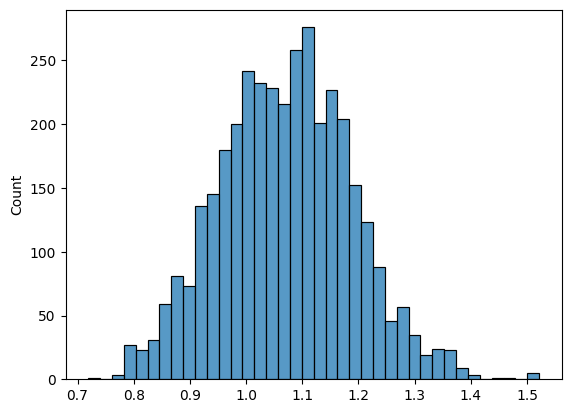

In [86]:
import seaborn as sns
sns.histplot(y_pred)

In [87]:
np.min(y_pred),np.max(y_pred)

(0.718965725860527, 1.521525171552673)

In [88]:
intercept_mean

0.03276121541732904

In [89]:
np.sum(np.round(y_pred)), len(y_pred), np.min(np.round(y_pred)), np.max(np.round(y_pred))

(3634.0, 3629, 1.0, 2.0)

In [90]:
np.sum(np.round(y_pred)==0)

0

<Axes: ylabel='Count'>

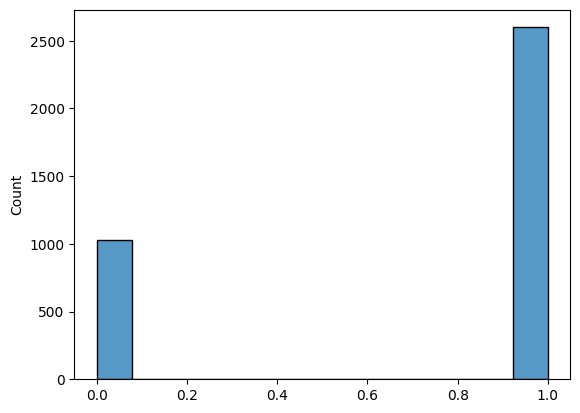

In [91]:
sns.histplot(y_pred_mode)

In [92]:
np.min(y_pred_mode), np.max(y_pred_mode)

(0.0, 1.0)

In [93]:
np.sum(y_pred_mode ==0), len(y_pred)

(1030, 3629)

In [99]:
#another metric
y_pred[(y_test==0).astype(int)].mean(), y_pred[(y_test==1).astype(int)].mean()

(0.9443104078744579, 0.959513719761169)

In [94]:
# Compute mse/mae at stint level
stint_m = compute_stint_metrics(poss_df[train_size:], y_pred)

MSE: 3.64
MAE: 1.50


#### Analyze Pymc results

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>]], dtype=object)

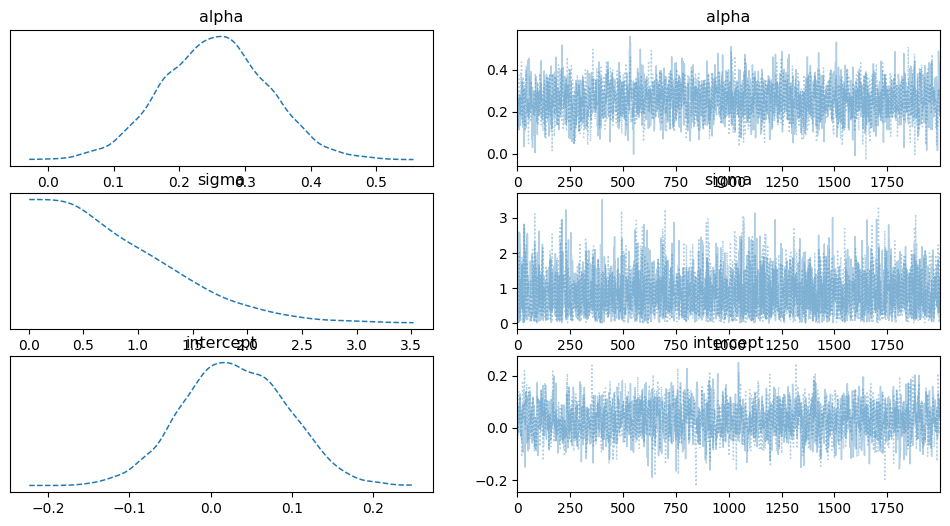

In [ ]:
az.plot_trace(trace, var_names=['alpha','sigma', 'intercept'] ,combined=True)

In [ ]:
summary_df = az.summary(trace, round_to=3, stat_funcs={'median': np.median})
summary_df.shape

(311, 10)

In [ ]:
offense_summary = summary_df.loc[summary_df.index.str.contains('beta')][:(n_features//2)]
# add player id and player name cols
offense_summary['playerId'] = players
offense_summary = offense_summary.merge(prior_df[['playerId','fullName','ortgPlayer','warp']], on='playerId', how='left')
offense_summary.shape

(154, 14)

In [ ]:
print(summary_df.loc[summary_df.index.str.contains('beta')]['mean'].mean())
print(offense_summary['mean'].mean())

-0.004081168831168831
-0.008246753246753247


In [ ]:
defense_summary = summary_df.loc[summary_df.index.str.contains('beta')][(n_features//2):]
defense_summary['playerId'] = players
defense_summary = defense_summary.merge(prior_df[['playerId','fullName','drtgPlayer']], on='playerId', how='left')
defense_summary.shape

(154, 13)

In [ ]:
# top offensive players
offense_summary.sort_values(by='mean', ascending=False).head(20)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,playerId,fullName,ortgPlayer,warp
41,0.205,0.115,-0.014,0.421,0.002,0.001,4484.255,3201.474,1.002,0.202,1969817,Roy Yuan,0.791532,-1.024356
116,0.132,0.059,0.015,0.239,0.001,0.001,5369.283,3206.353,1.000,0.132,1309579,Keion Brooks Jr.,0.112560,3.881014
123,0.132,0.055,0.023,0.229,0.001,0.001,6051.870,3176.110,1.000,0.132,1602971,Deivon Smith,0.065275,2.999284
102,0.108,0.056,-0.001,0.209,0.001,0.001,6239.286,3579.300,1.000,0.109,979279,Jermaine Couisnard,0.039387,3.940074
25,0.103,0.055,0.002,0.207,0.001,0.001,5249.857,3148.253,1.000,0.103,1606251,Tristan da Silva,0.128103,4.087134
149,0.103,0.053,-0.001,0.198,0.001,0.001,5834.543,3162.124,1.000,0.103,1916388,Bryant Selebangue,0.102655,0.331924
35,0.099,0.055,0.000,0.202,0.001,0.001,5701.598,3298.622,1.001,0.099,1600136,Pelle Larsson,0.164481,2.108384
18,0.098,0.052,-0.000,0.196,0.001,0.001,5438.503,2939.876,1.001,0.098,1602614,Brandon Angel,0.139504,0.508764
135,0.098,0.054,-0.006,0.200,0.001,0.001,6538.692,3034.160,1.000,0.098,1912256,Michael Rataj,-0.021447,0.613664
131,0.084,0.057,-0.025,0.188,0.001,0.001,8168.935,2859.685,1.001,0.084,1912250,Tyler Bilodeau,0.110706,2.273034


In [ ]:
# top defensive players
defense_summary.sort_values(by='mean', ascending=True).head(20)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,playerId,fullName,drtgPlayer
44,-0.139,0.054,-0.239,-0.036,0.001,0.001,5792.294,3107.745,1.000,-0.139,1920157,Jaden Bradley,-0.065765
34,-0.116,0.054,-0.214,-0.010,0.001,0.001,6884.743,2850.831,1.002,-0.117,1696901,Jaylon Tyson,0.027262
36,-0.104,0.060,-0.215,0.010,0.001,0.001,4086.002,2981.059,1.000,-0.104,1614984,Braxton Meah,-0.032421
47,-0.102,0.104,-0.291,0.094,0.001,0.001,6170.112,2694.100,1.000,-0.102,1908908,Jack McCloskey,-0.404709
135,-0.099,0.052,-0.199,-0.006,0.001,0.001,5788.943,2977.332,1.003,-0.099,1912256,Michael Rataj,0.011414
101,-0.095,0.053,-0.197,0.005,0.001,0.001,6292.590,3083.351,1.002,-0.095,1309512,N'Faly Dante,-0.078220
144,-0.093,0.061,-0.209,0.018,0.001,0.001,5796.407,3660.368,1.000,-0.093,1720267,Lawson Lovering,-0.037821
147,-0.082,0.098,-0.264,0.106,0.001,0.001,8185.685,2842.711,1.001,-0.081,1720274,Jack Pease,-0.290177
7,-0.073,0.050,-0.168,0.018,0.001,0.000,7267.624,2631.366,1.001,-0.072,2112552,Kwame Evans Jr.,-0.049572
29,-0.070,0.050,-0.165,0.024,0.001,0.001,5962.661,3042.908,1.000,-0.070,977528,Michael Jones,0.049699


## Fit Bayesian model with Ortg/Drtg priors, AND Placeholders

In [53]:
max_players_mins = prior_df.player_mins.max()
player_min_thresh = 0.15 * max_players_mins # setting it to 15% of max mins currently
print(max_players_mins, player_min_thresh)

player_w_mins_prior_df = prior_df[prior_df.player_mins > player_min_thresh]
players_with_mins = list(player_w_mins_prior_df.playerId)
num_players_w_mins = len(players_with_mins)
print(num_players_w_mins)

1298.1400000000003 194.72100000000003
106


In [54]:
# Conference priors
conf_query = '''

with
  conference_stats as (
    select
      competitionId
      ,divisionId
      ,conferenceId
      ,ortg/100 as conf_ortg
      ,drtg/100 as conf_drtg
    from models.gs__conference_agg_stats
    where competitionId = 36046 and divisionId = 1 and isOffense is true and scope = 'season'
  ),

  division_stats as (
    select
      competitionId
      ,divisionId
      ,ortg/100 as division_ortg
      ,drtg/100 as division_drtg
    from models.gs__league_agg_stats
    where competitionId = 36046 and divisionId = 1 and isOffense is true and scope = 'season'
  ),

  conf_and_div_stats as (
    select
      a.*
      ,b.division_ortg
      ,b.division_drtg
      ,b.division_ortg - a.conf_ortg as drtg_adj_for_conf -- note drtgAdj is based on offensive ratings
      ,b.division_drtg - a.conf_drtg as ortg_adj_for_conf -- note ortgAdj is based on defensice ratings
    from conference_stats as a
    left join division_stats as b
      on a.competitionId = b.competitionId
      and a.divisionId = b.divisionId
  )


select * from conf_and_div_stats
order by ortg_adj_for_conf desc
'''
conf_priors_df = bq.query(conf_query).to_dataframe()
conf_priors_df.shape

(34, 9)

In [55]:
conf_priors_df.head()

,competitionId,divisionId,conferenceId,conf_ortg,conf_drtg,division_ortg,division_drtg,drtg_adj_for_conf,ortg_adj_for_conf
0,36046,1,60,1.113086,1.021347,1.07323,1.07323,-0.039856,0.051883
1,36046,1,88,1.029888,1.042502,1.07323,1.07323,0.043342,0.030728
2,36046,1,36,1.041535,1.046085,1.07323,1.07323,0.031695,0.027145
3,36046,1,18,1.039636,1.054673,1.07323,1.07323,0.033594,0.018557
4,36046,1,19,1.034454,1.056203,1.07323,1.07323,0.038776,0.017027


In [56]:
# center the ratings
conf_priors_df['conf_ortg'] -= conf_priors_df['conf_ortg'].mean()
conf_priors_df['conf_drtg'] -= conf_priors_df['conf_drtg'].mean()

conf_priors_df['division_ortg'] -= conf_priors_df['division_ortg'].mean()
conf_priors_df['division_drtg'] -= conf_priors_df['division_drtg'].mean()

conf_priors_df['drtg_adj_for_conf'] -= conf_priors_df['drtg_adj_for_conf'].mean()
conf_priors_df['ortg_adj_for_conf'] -= conf_priors_df['ortg_adj_for_conf'].mean()

# round up after centering
conf_priors_df['conf_ortg'] = conf_priors_df['conf_ortg'].round(3)
conf_priors_df['conf_drtg'] = conf_priors_df['conf_drtg'].round(3)
conf_priors_df['division_ortg'] = conf_priors_df['division_ortg'].round(3)
conf_priors_df['division_drtg'] = conf_priors_df['division_drtg'].round(3)
conf_priors_df['drtg_adj_for_conf'] = conf_priors_df['drtg_adj_for_conf'].round(3)
conf_priors_df['ortg_adj_for_conf'] = conf_priors_df['ortg_adj_for_conf'].round(3)


In [57]:
# All unique conferences in dataset
conferences = list(poss_df['offense_conf']) + list(poss_df['defense_conf'])
conferences = list(set(conferences))
num_conferences = len(conferences)
conferences

[74]

In [58]:
#filter and order conf priors df by conferences in dataset
conf_priors_df = pd.DataFrame({'conferenceId':conferences}).merge(conf_priors_df, on='conferenceId', how='left')
conf_priors_df

,conferenceId,competitionId,divisionId,conf_ortg,conf_drtg,division_ortg,division_drtg,drtg_adj_for_conf,ortg_adj_for_conf
0,74,36046,1,0.029,-0.018,-0.0,-0.0,-0.029,0.018


In [59]:
#conf_priors_df.isnull().sum()  # check for nulls

In [60]:
# Recreate model df to add the new cols

# Design matrix has columns in this order -->  offense cols for each player,  defense cols for each player,
# offense cols for each conference, defense cols for each conference, 'is_home' column

In [61]:
# initiate empty sparse matrix for the design matrix
from scipy.sparse import lil_matrix

num_rows = len(poss_df)
num_players_w_mins = len(players_with_mins)
# 1 extra col for is_home col
sparse_matrix = lil_matrix((num_rows, (2*num_players_w_mins) + (2*num_conferences) + 1), dtype=float)

In [62]:
%%time

player_id_to_index = {player_id: idx for idx, player_id in enumerate(players_with_mins)}
conf_id_to_index = {conf_id: idx for idx, conf_id in enumerate(conferences)}

def update_sparse_matrix(row_idx, players, player_offset, conference, conf_offset):
  for player in players:
    if player in player_id_to_index:
      col_idx = player_id_to_index[player] + player_offset
      sparse_matrix[row_idx, col_idx] = 1
    else:
      # increase player's conference column by 1 if he/she doesnt meet the mins threshold
      col_idx = conf_id_to_index[conference] + conf_offset
      sparse_matrix[row_idx, col_idx] += 1


# Loop through each row in the DataFrame
for row_idx, row in poss_df.iterrows():
    off_players = list(map(int,row['offOnCtRapmRaw'].split('-')))
    def_players = list(map(int, row['defOnCtRapmRaw'].split('-')))
    off_conf = row['offense_conf']
    def_conf = row['defense_conf']

    # Update the sparse matrix for offense players
    update_sparse_matrix(row_idx, off_players, player_offset=0, conference=off_conf, conf_offset=2*num_players_w_mins)

    # Update the sparse matrix for defense players
    update_sparse_matrix(row_idx, def_players, player_offset=num_players_w_mins, \
                         conference=def_conf, conf_offset=(2*num_players_w_mins)+num_conferences)

    # update 'is_home' col -> last col in design matrix
    sparse_matrix[row_idx, -1] = int(row['is_home'])


CPU times: user 2.11 s, sys: 20.4 ms, total: 2.13 s
Wall time: 2.14 s


In [63]:
# Convert the sparse matrix to a CSR format (more efficient for computations)
X_sparse_full = sparse_matrix.tocsr()

In [64]:
X_sparse_full.shape

(18142, 215)

In [65]:
# a = X_sparse_full[:,-3].toarray()
# a.shape

In [66]:
y_obs = poss_df['ptsScored']
print(np.mean(y_obs>0))

0.488810494984015


In [67]:
n_samples = len(poss_df)
n_features = X_sparse_full.shape[1]

In [68]:
n_samples,n_features

(18142, 215)

In [69]:
# Player (beta) priors
off_def_priors = np.array(pd.concat([player_w_mins_prior_df['ortgPlayer'],\
                                     player_w_mins_prior_df['drtgPlayer']])).reshape((2*num_players_w_mins,1))

print(off_def_priors.shape)

# Conference (beta) priors
conf_priors = np.array(pd.concat([conf_priors_df['conf_ortg'],\
                                     conf_priors_df['conf_drtg']])).reshape((2*num_conferences,1))
print(conf_priors.shape)

# 'is_home' column (beta) prior
print(np.mean(poss_df.loc[poss_df.is_home == 1,'ptsScored']) - np.mean(poss_df.loc[poss_df.is_home==0,'ptsScored']))
is_home_prior = np.array(0.1).reshape((1,1)) # setting it using the output from line above ^
print(is_home_prior.shape)

# all beta priors
beta_priors = np.concatenate((off_def_priors, conf_priors, is_home_prior), axis=0)
print(beta_priors.shape)

(212, 1)
(2, 1)
0.08153987835704601
(1, 1)
(215, 1)


### Fit Normal Model

In [ ]:
%%time

# Using 4-fold cross validation for evaluation

import pymc as pm
import numpy as np
import pytensor
import pytensor.tensor as pt
import pytensor.sparse as sparse
import scipy.sparse as sp

kf = KFold(n_splits=4)
mse_values = []

# Define the bayesian model using PyMC
for train_index, test_index in kf.split(X_sparse_full):
  X_train_sparse, X_test_sparse = X_sparse_full[train_index], X_sparse_full[test_index]
  y_train, y_test = y_obs[train_index], y_obs[test_index]

  with pm.Model() as model:
    # Define priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=1)  # TODO- what mean and sigma to choose here?
    beta = pm.Normal("beta", mu=alpha * beta_priors, sigma=0.1, shape=(n_features,1))  # sigma arg here represents standard dev., not variance
    sigma = pm.HalfNormal("sigma", sigma=1)

    print('dot product')
    X_train_sparse_pt = sparse.as_sparse_variable(X_train_sparse)
    mu = sparse.basic.structured_dot(X_train_sparse_pt, beta).flatten()

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y_train)
    print('likelihood defined')

    # Sample from the posterior distribution
    trace = pm.sample(2000, return_inferencedata=True) #tune = 500 --tuning steps

    # Make predictions on the test set
    print('evaluating the  model')
    beta=trace.posterior['beta'].values.squeeze(axis=-1)
    beta=np.vstack(beta)
    beta_hat = beta.mean(axis=0)
    print(beta_hat.shape)
    y_pred = X_test_sparse @ beta_hat
    y_pred_mean = np.mean(y_pred)
    print('mean prediction', y_pred_mean)

    # Evaluate the model
    mse = mean_squared_error(y_pred, y_test)
    mse_values.append(mse)
    mae = mean_absolute_error(y_pred, y_test)
    print(f"MSE: {mse:.2f}")
    print(f"MAE: {mae:.2f}")
    print('binary classification error', 1-accuracy_score(y_pred>y_pred_mean, y_test>0)) # predict 1 pts_scored when y_pred >y_pred_mean
    print('overall classification error',1-accuracy_score(np.round(y_pred), y_test))


In [ ]:
# # average mse
# np.mean(mse_values)

2.320401202199155

In [117]:
%%time

# 1-fold validation

import pymc as pm
import numpy as np
import pytensor
import pytensor.tensor as pt
import pytensor.sparse as sparse
import scipy.sparse as sp


# Define the bayesian model using PyMC
train_size = int(0.8 * n_samples)
X_train_sparse, X_test_sparse = X_sparse_full[:train_size], X_sparse_full[train_size:]
y_train, y_test = y_obs[:train_size], y_obs[train_size:]

with pm.Model() as model:
  # Define priors for unknown model parameters
  alpha = pm.Normal("alpha", mu=0, sigma=1)  # TODO- what mean and sigma to choose here?
  beta = pm.Normal("beta", mu=alpha * beta_priors, sigma=0.1, shape=(n_features,1))  # sigma arg here represents standard dev., not variance
  sigma = pm.HalfNormal("sigma", sigma=1)

  print('dot product')
  X_train_sparse_pt = sparse.as_sparse_variable(X_train_sparse)
  mu = sparse.basic.structured_dot(X_train_sparse_pt, beta).flatten()

  # Likelihood (sampling distribution) of observations
  Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y_train)
  print('likelihood defined')

  # Sample from the posterior distribution
  trace = pm.sample(2000, return_inferencedata=True) #tune = 500 --tuning steps

  # Make predictions on the test set
  print('evaluating the  model')
  beta=trace.posterior['beta'].values.squeeze(axis=-1)
  beta=np.vstack(beta)
  beta_hat = beta.mean(axis=0)
  print(beta_hat.shape)
  y_pred = X_test_sparse @ beta_hat
  y_pred_mean = np.mean(y_pred)
  print('mean prediction', y_pred_mean)

  # Evaluate the model
  mse = mean_squared_error(y_pred, y_test)
  mae = mean_absolute_error(y_pred, y_test)
  print(f"MSE: {mse:.2f}")
  print(f"MAE: {mae:.2f}")
  print('binary classification error', 1-accuracy_score(y_pred>y_pred_mean, y_test>0)) # predict 1 pts_scored when y_pred >y_pred_mean
  print('overall classification error',1-accuracy_score(np.round(y_pred), y_test))


dot product
likelihood defined


evaluating the  model
(215,)
mean prediction 1.060966184174908
MSE: 1.34
MAE: 1.09
binary classification error 0.4709286304767153
overall classification error 0.9583907412510333
CPU times: user 3min 19s, sys: 1.36 s, total: 3min 21s
Wall time: 3min 25s


<Axes: ylabel='Count'>

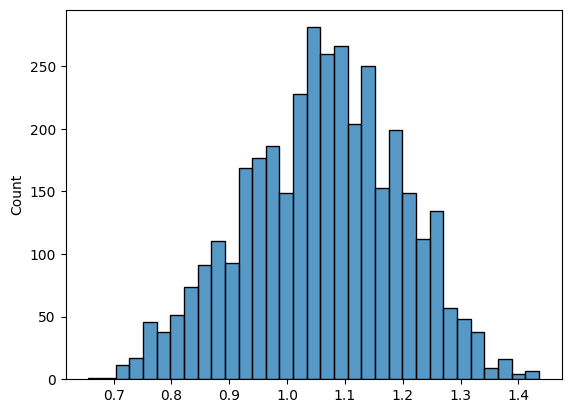

In [118]:
import seaborn as sns
sns.histplot(y_pred)

<Axes: ylabel='Count'>

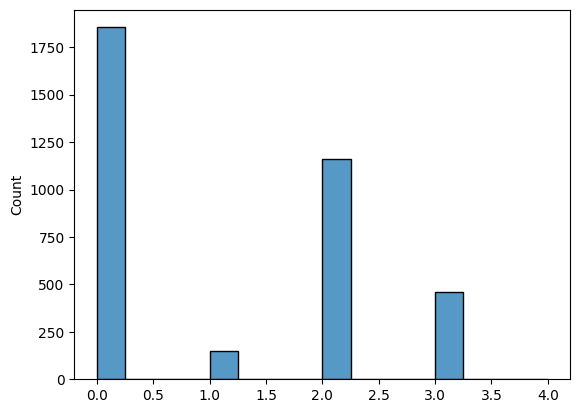

In [119]:
sns.histplot(np.array(y_test))

In [120]:
np.max(y_pred), np.min(y_pred)

(1.4358094811615842, 0.6560052381340111)

In [121]:
np.sum(np.round(y_pred)) #  all preds = 1 when rounded

3629.0

In [130]:
#another metric
y_pred[(y_test==0).astype(int)].mean(), y_pred[(y_test==1).astype(int)].mean(), y_pred[(y_test>1).astype(int)].mean()

(0.9065810217815248, 0.8736933089293305, 0.9021033519565782)

In [136]:
# Compute mse/mae at stint level
stint_m = compute_stint_metrics(poss_df[train_size:], y_pred)

MSE: 3.62
MAE: 1.50
binary classification error 0.42109090909090907


#### Analyze Pymc results

In [137]:
summary_df = az.summary(trace, round_to=3, stat_funcs={'median': np.median})
summary_df.shape

(217, 10)

In [142]:
offense_summary = summary_df.loc[summary_df.index.str.contains('beta')][:num_players_w_mins]
# add player id and player name cols
offense_summary['playerId'] = players_with_mins
offense_summary = offense_summary.merge(prior_df[['playerId','fullName','ortgPlayer','warp']], on='playerId', how='left')
offense_summary.shape

(106, 14)

In [143]:
# why not centered closer to 0?
print(summary_df.loc[summary_df.index.str.contains('beta')]['mean'].mean())
print(offense_summary['mean'].mean())

0.0890418604651163
0.09249056603773587


In [148]:
defense_summary = summary_df.loc[summary_df.index.str.contains('beta')][num_players_w_mins:(2*num_players_w_mins)]
defense_summary['playerId'] = players_with_mins
defense_summary = defense_summary.merge(prior_df[['playerId','fullName','drtgPlayer']], on='playerId', how='left')
defense_summary.shape

(106, 13)

In [149]:
# top offensive players
offense_summary.sort_values(by='mean', ascending=False).head(20)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,playerId,fullName,ortgPlayer,warp
77,0.237,0.064,0.116,0.354,0.001,0.001,4499.238,3259.558,1.000,0.236,1309579,Keion Brooks Jr.,0.112560,3.881014
83,0.212,0.058,0.100,0.319,0.001,0.001,4927.385,2898.750,1.000,0.211,1602971,Deivon Smith,0.065275,2.999284
66,0.208,0.062,0.095,0.321,0.001,0.001,4963.910,3199.479,1.000,0.208,979279,Jermaine Couisnard,0.039387,3.940074
19,0.198,0.060,0.091,0.313,0.001,0.001,4791.489,3080.382,1.000,0.197,1606251,Tristan da Silva,0.128103,4.087134
12,0.196,0.058,0.090,0.305,0.001,0.001,4218.015,2924.738,1.001,0.196,1602614,Brandon Angel,0.139504,0.508764
26,0.194,0.063,0.067,0.305,0.001,0.001,4262.643,2999.739,1.001,0.194,1600136,Pelle Larsson,0.164481,2.108384
90,0.193,0.059,0.080,0.301,0.001,0.001,4207.166,2787.780,1.001,0.194,1912250,Tyler Bilodeau,0.110706,2.273034
48,0.190,0.059,0.084,0.307,0.001,0.001,4349.866,3094.220,1.000,0.190,1731840,Jaylen Wells,0.212283,3.187024
103,0.176,0.059,0.065,0.288,0.001,0.001,4444.071,3324.675,1.000,0.176,1892849,Isaac Jones,0.141088,4.226394
102,0.174,0.058,0.064,0.282,0.001,0.001,4463.721,2934.887,1.000,0.175,1916388,Bryant Selebangue,0.102655,0.331924


In [151]:
# Top defensive players - - similar to 'no placeholders' result when filtering it for players with high mins

# Players Mccloskey and Pease dont show up because they didnt meet minute threshold (so not in design matrix here)
defense_summary.sort_values(by='mean', ascending=True).head(20)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,playerId,fullName,drtgPlayer
29,-0.037,0.057,-0.138,0.075,0.001,0.001,3994.089,2757.060,1.000,-0.036,1920157,Jaden Bradley,-0.065765
27,-0.033,0.063,-0.150,0.091,0.001,0.001,4386.080,3044.747,1.000,-0.032,1614984,Braxton Meah,-0.032421
65,-0.009,0.060,-0.118,0.110,0.001,0.001,4215.537,3137.409,1.001,-0.010,1309512,N'Faly Dante,-0.078220
25,-0.009,0.062,-0.122,0.108,0.001,0.001,4944.588,2844.042,1.000,-0.009,1696901,Jaylon Tyson,0.027262
11,-0.000,0.066,-0.122,0.124,0.001,0.001,4059.063,3329.390,1.000,-0.002,1898036,Adem Bona,-0.092994
98,0.001,0.064,-0.111,0.138,0.001,0.001,4071.814,2983.428,1.000,0.002,1720267,Lawson Lovering,-0.037821
49,0.010,0.067,-0.116,0.132,0.001,0.001,4524.677,3275.279,1.002,0.009,1329924,Mahamadou Diawara,-0.004131
37,0.013,0.063,-0.112,0.127,0.001,0.001,5582.999,2977.191,1.001,0.013,1716944,Justin Rochelin,-0.003132
35,0.015,0.064,-0.105,0.137,0.001,0.001,3468.259,3153.624,1.000,0.012,2093257,Rueben Chinyelu,-0.117027
93,0.018,0.059,-0.093,0.130,0.001,0.001,4700.603,3314.292,1.000,0.020,1912256,Michael Rataj,0.011414


#### Retry with separate hyperpriors

In [ ]:
# Applying different hyperprior to player and non-player coeffs
# Result so far - NO difference in performance!!

In [ ]:
n_features

215

In [ ]:
n_player_features = 2*num_players_w_mins
n_player_features

212

In [ ]:
player_priors = beta_priors[:n_player_features]
print(player_priors.shape)
other_priors = beta_priors[n_player_features:]
print(other_priors.shape)

(212, 1)
(3, 1)


In [ ]:
%%time

# 1-fold validation

import pymc as pm
import numpy as np
import pytensor
import pytensor.tensor as pt
import pytensor.sparse as sparse
import scipy.sparse as sp

# Define the bayesian model using PyMC
train_size = int(0.8 * n_samples)
X_train_sparse, X_test_sparse = X_sparse_full[:train_size], X_sparse_full[train_size:]
y_train, y_test = y_obs[:train_size], y_obs[train_size:]

with pm.Model() as model:
  # Define priors for unknown model parameters
  alpha = pm.Normal("alpha", mu=0, sigma=1)  # TODO- what mean and sigma to choose here?
  alpha2 = pm.Normal("alpha2", mu=0, sigma=1)
  beta_players = pm.Normal("beta_players", mu=alpha * player_priors, sigma=0.1, shape=(n_player_features,1))  # sigma arg here represents standard dev., not variance
  beta_other = pm.Normal("beta_other", mu=alpha2 * other_priors, sigma=0.1, shape=(n_features-n_player_features,1))
  sigma = pm.HalfNormal("sigma", sigma=1)

  print('dot product')
  beta = pm.math.concatenate([beta_players, beta_other], axis=0)
  X_train_sparse_pt = sparse.as_sparse_variable(X_train_sparse)
  mu = sparse.basic.structured_dot(X_train_sparse_pt, beta).flatten()

  # Likelihood (sampling distribution) of observations
  Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y_train)
  print('likelihood defined')

  # Sample from the posterior distribution
  trace = pm.sample(2000, return_inferencedata=True) #tune = 500 --tuning steps

  # Make predictions on the test set
  print('evaluating the  model')
  beta1=trace.posterior['beta_players'].values.squeeze(axis=-1)
  beta1=np.vstack(beta1)
  beta1_hat = beta1.mean(axis=0)
  print(beta1_hat.shape)

  beta2=trace.posterior['beta_other'].values.squeeze(axis=-1)
  beta2=np.vstack(beta2)
  beta2_hat = beta2.mean(axis=0)
  print(beta2_hat.shape)

  beta_hat = np.concatenate((beta1_hat, beta2_hat), axis=0)
  print(beta_hat.shape)
  y_pred = X_test_sparse @ beta_hat
  y_pred_mean = np.mean(y_pred)
  print('mean prediction', y_pred_mean)

  # Evaluate the model
  mse = mean_squared_error(y_pred, y_test)
  mae = mean_absolute_error(y_pred, y_test)
  print(f"MSE: {mse:.2f}")
  print(f"MAE: {mae:.2f}")
  print('binary classification error', 1-accuracy_score(y_pred>y_pred_mean, y_test>0)) # predict 1 pts_scored when y_pred >y_pred_mean
  print('overall classification error',1-accuracy_score(np.round(y_pred), y_test))


dot product
likelihood defined


evaluating the  model
(212,)
(3,)
(215,)
mean prediction 1.0612939858275094
MSE: 1.34
MAE: 1.09
binary classification error 0.4728575365114357
overall classification error 0.9583907412510333
CPU times: user 3min 23s, sys: 1.35 s, total: 3min 25s
Wall time: 3min 31s


In [ ]:
#another metric
y_pred[(y_test==0).astype(int)].mean(), y_pred[(y_test==1).astype(int)].mean(), y_pred[(y_test>1).astype(int)].mean()

(0.9086873291841807, 0.8756236351458317, 0.904185699479429)

In [ ]:
# Compute mse/mae at stint level
stint_m = compute_stint_metrics(poss_df[train_size:], y_pred)

MSE: 3.62
MAE: 1.50
binary classification error 0.42181818181818187


In [ ]:
summary_df = az.summary(trace, round_to=3, stat_funcs={'median': np.median})
summary_df.shape

(218, 10)

In [ ]:
summary_df.loc[summary_df.index.str.contains('alpha')]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median
alpha,0.405,0.098,0.235,0.609,0.002,0.001,4236.317,2767.247,1.000,0.403
alpha2,0.473,0.694,-0.782,1.810,0.009,0.010,6492.682,2983.888,1.001,0.477


In [ ]:
offense_summary = summary_df.loc[summary_df.index.str.contains('beta_players')][:num_players_w_mins]
# add player id and player name cols
offense_summary['playerId'] = players_with_mins
offense_summary = offense_summary.merge(prior_df[['playerId','fullName','ortgPlayer','warp']], on='playerId', how='left')
offense_summary.shape

(106, 14)

In [ ]:
defense_summary = summary_df.loc[summary_df.index.str.contains('beta_players')][num_players_w_mins:(2*num_players_w_mins)]
defense_summary['playerId'] = players_with_mins
defense_summary = defense_summary.merge(prior_df[['playerId','fullName','drtgPlayer']], on='playerId', how='left')
defense_summary.shape

(106, 13)

In [ ]:
# top offensive players
offense_summary.sort_values(by='mean', ascending=False).head(20)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,playerId,fullName,ortgPlayer,warp
77,0.238,0.064,0.120,0.358,0.001,0.001,5224.664,3036.438,1.000,0.237,1309579,Keion Brooks Jr.,0.112560,3.881014
83,0.212,0.058,0.102,0.317,0.001,0.001,5330.375,2694.469,1.000,0.212,1602971,Deivon Smith,0.065275,2.999284
66,0.209,0.061,0.101,0.329,0.001,0.001,4979.829,2914.661,1.001,0.209,979279,Jermaine Couisnard,0.039387,3.940074
19,0.198,0.060,0.087,0.313,0.001,0.001,5475.268,3258.319,1.000,0.199,1606251,Tristan da Silva,0.128103,4.087134
12,0.196,0.057,0.088,0.301,0.001,0.001,5920.256,3223.963,1.001,0.196,1602614,Brandon Angel,0.139504,0.508764
26,0.193,0.062,0.079,0.307,0.001,0.001,5294.685,3073.598,1.001,0.193,1600136,Pelle Larsson,0.164481,2.108384
90,0.192,0.060,0.082,0.306,0.001,0.001,4929.466,2773.624,1.000,0.191,1912250,Tyler Bilodeau,0.110706,2.273034
48,0.190,0.060,0.078,0.306,0.001,0.001,5667.965,3221.035,1.000,0.190,1731840,Jaylen Wells,0.212283,3.187024
103,0.176,0.058,0.069,0.286,0.001,0.001,5935.408,3155.359,1.000,0.175,1892849,Isaac Jones,0.141088,4.226394
93,0.175,0.059,0.064,0.284,0.001,0.001,5546.424,3183.247,1.001,0.176,1912256,Michael Rataj,-0.021447,0.613664


In [ ]:
# top defensive players  - similar to 'no placeholders' version after filtering it for high min players
defense_summary.sort_values(by='mean', ascending=True).head(20)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,playerId,fullName,drtgPlayer
27,-0.036,0.063,-0.156,0.081,0.001,0.001,4759.277,3087.751,1.000,-0.036,1614984,Braxton Meah,-0.032421
29,-0.036,0.057,-0.147,0.067,0.001,0.001,5330.829,3544.453,1.000,-0.036,1920157,Jaden Bradley,-0.065765
65,-0.009,0.058,-0.115,0.106,0.001,0.001,5057.056,3010.395,1.001,-0.009,1309512,N'Faly Dante,-0.078220
25,-0.008,0.061,-0.127,0.104,0.001,0.001,5665.342,2797.311,1.001,-0.009,1696901,Jaylon Tyson,0.027262
11,0.001,0.066,-0.124,0.122,0.001,0.001,5654.559,3437.098,1.001,0.001,1898036,Adem Bona,-0.092994
98,0.002,0.066,-0.118,0.126,0.001,0.001,5177.818,3201.208,1.000,0.001,1720267,Lawson Lovering,-0.037821
49,0.011,0.067,-0.107,0.142,0.001,0.001,5031.748,3307.859,1.001,0.011,1329924,Mahamadou Diawara,-0.004131
35,0.012,0.064,-0.112,0.124,0.001,0.001,5031.632,3331.139,1.001,0.011,2093257,Rueben Chinyelu,-0.117027
37,0.012,0.061,-0.111,0.122,0.001,0.001,7424.011,3130.449,1.000,0.013,1716944,Justin Rochelin,-0.003132
93,0.017,0.057,-0.087,0.121,0.001,0.001,6278.353,3276.933,1.000,0.017,1912256,Michael Rataj,0.011414


### Fit Poisson Model

In [80]:
%%time
# 1-fold validation , with Poisson distribution!

# Define the bayesian model using PyMC
train_size = int(0.8 * n_samples)
X_train_sparse, X_test_sparse = X_sparse_full[:train_size], X_sparse_full[train_size:]
y_train, y_test = y_obs[:train_size], y_obs[train_size:]

with pm.Model() as model:
  # Define priors for unknown model parameters
  alpha = pm.Normal("alpha", mu=0, sigma=1)  # TODO- what mean and sigma to choose here?
  beta = pm.Normal("beta", mu=alpha * beta_priors, sigma=0.1, shape=(n_features,1))  # sigma arg here represents standard dev., not variance
  sigma = pm.HalfNormal("sigma", sigma=1)
  intercept = pm.Normal("intercept", mu=0, sigma=10)

  # Define the expected value of the Poisson distribution -> model: Y|x1,x2,.. ~ Poisson(mu=exp(b0 + b1*x1 + b2*x2 + ....))
  print('dot product')
  X_train_sparse_pt = sparse.as_sparse_variable(X_train_sparse)
  log_mu = sparse.basic.structured_dot(X_train_sparse_pt, beta).flatten() + intercept
  print(log_mu.shape)
  mu = pm.math.exp(log_mu)

  # Likelihood (sampling distribution) of observations
  Y_obs = pm.Poisson("Y_obs", mu=mu, observed=y_train) #sigma = mu in poisson model by design
  print('likelihood defined')

  # Sample from the posterior distribution
  trace = pm.sample(2000, return_inferencedata=True) #tune = 500 --tuning steps

  # Make predictions on the test set
  print('evaluating the  model')
  #posterior_predictive = pm.sample_posterior_predictive(trace, var_names=["beta"])
  beta=trace.posterior['beta'].values.squeeze(axis=-1)
  beta=np.vstack(beta)
  beta_hat = beta.mean(axis=0)
  print(beta_hat.shape)
  intercept_samples = trace.posterior['intercept'].values
  intercept_mean = intercept_samples.mean()
  #print(intercept_mean.shape)
  # predict expected value at each test observation
  y_pred = np.exp(X_test_sparse @ beta_hat + intercept_mean)
  # predict mode (most likely class) at each test observation
  y_pred_mode = np.zeros(len(y_pred))
  for i in range(len(y_pred)):
      mu = y_pred[i]
      probabilities = [poisson.pmf(k, mu) for k in range(6)]
      y_pred_mode[i] = np.argmax(probabilities)

  # Evaluate the model
  mse = mean_squared_error(y_pred, y_test)
  mae = mean_absolute_error(y_pred, y_test)
  print(f"MSE: {mse:.2f}")
  print(f"MAE: {mae:.2f}")
  print('binary classification error', 1-accuracy_score(y_pred_mode>0, y_test>0))
  print('overall classification error',1-accuracy_score(np.round(y_pred), y_test))


dot product
Shape.0
likelihood defined


evaluating the  model
(215,)
MSE: 1.34
MAE: 1.09
binary classification error 0.4860843207495178
overall classification error 0.9583907412510333
CPU times: user 4min 56s, sys: 2.11 s, total: 4min 59s
Wall time: 5min 53s


<Axes: ylabel='Count'>

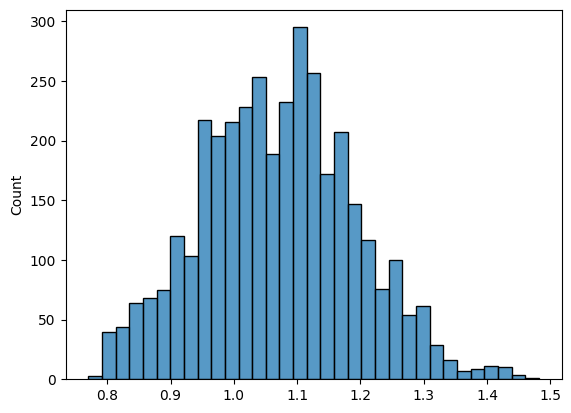

In [81]:
import seaborn as sns
sns.histplot(y_pred)

<Axes: ylabel='Count'>

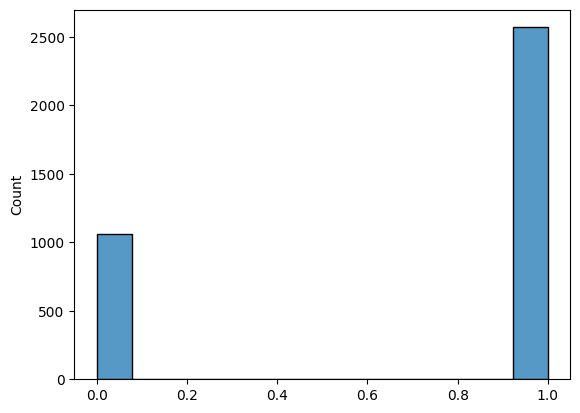

In [82]:
sns.histplot(y_pred_mode)

In [83]:
np.max(y_pred), np.min(y_pred)

(1.482285949285628, 0.7699771428860521)

In [84]:
intercept_mean

-0.04897711228441163

In [85]:
np.sum(np.round(y_pred)), len(y_pred), np.min(np.round(y_pred)), np.max(np.round(y_pred))

(3629.0, 3629, 1.0, 1.0)

In [86]:
#another metric
y_pred[(y_test==0).astype(int)].mean(), y_pred[(y_test==1).astype(int)].mean(), y_pred[(y_test>1).astype(int)].mean()

(0.9365344793864551, 0.9274866215754051, 0.9353026114215703)

In [89]:
# Compute mse/mae at stint level
stint_m = compute_stint_metrics(poss_df[train_size:], y_pred)

MSE: 3.63
MAE: 1.50
binary classification error 0.42109090909090907


#### Analyze Pymc results

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>]], dtype=object)

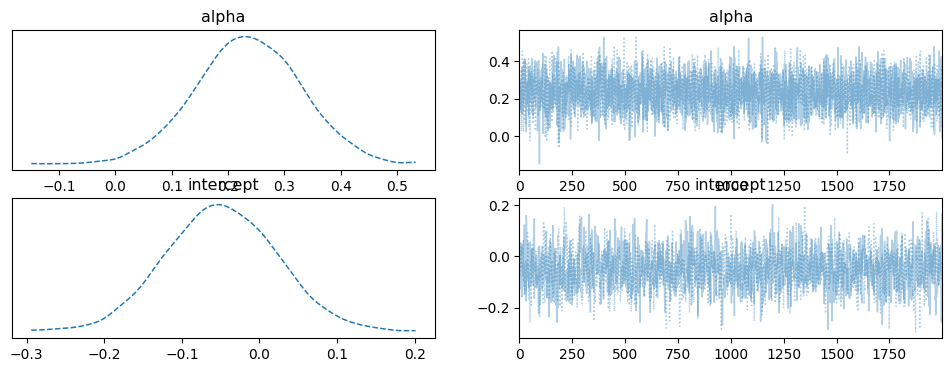

In [90]:
az.plot_trace(trace, var_names=['alpha','intercept'] ,combined=True)

In [91]:
summary_df = az.summary(trace, round_to=3, stat_funcs={'median': np.median})
summary_df.shape

(218, 10)

In [92]:
offense_summary = summary_df.loc[summary_df.index.str.contains('beta')][:num_players_w_mins]
# add player id and player name cols
offense_summary['playerId'] = players_with_mins
offense_summary = offense_summary.merge(prior_df[['playerId','fullName','ortgPlayer','warp']], on='playerId', how='left')
offense_summary.shape

(106, 14)

In [93]:
print(summary_df.loc[summary_df.index.str.contains('beta')]['mean'].mean())
print(offense_summary['mean'].mean())

0.0020186046511627897
0.0038679245283018853


In [94]:
defense_summary = summary_df.loc[summary_df.index.str.contains('beta')][num_players_w_mins:(2*num_players_w_mins)]
defense_summary['playerId'] = players_with_mins
defense_summary = defense_summary.merge(prior_df[['playerId','fullName','drtgPlayer']], on='playerId', how='left')
defense_summary.shape

(106, 13)

In [95]:
# top offensive players
offense_summary.sort_values(by='mean', ascending=False).head(20) # NOTE: coeffs on diff scale from normal model here!

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,playerId,fullName,ortgPlayer,warp
77,0.138,0.058,0.027,0.245,0.001,0.001,4377.124,2974.225,1.003,0.137,1309579,Keion Brooks Jr.,0.112560,3.881014
83,0.123,0.055,0.018,0.224,0.001,0.001,5279.211,3084.860,1.001,0.124,1602971,Deivon Smith,0.065275,2.999284
66,0.109,0.059,-0.002,0.217,0.001,0.001,5850.432,3029.580,1.000,0.110,979279,Jermaine Couisnard,0.039387,3.940074
19,0.108,0.054,0.008,0.211,0.001,0.001,5481.396,2860.570,1.001,0.108,1606251,Tristan da Silva,0.128103,4.087134
12,0.096,0.052,0.001,0.199,0.001,0.001,5583.495,2980.944,1.000,0.097,1602614,Brandon Angel,0.139504,0.508764
102,0.091,0.052,-0.009,0.185,0.001,0.001,5697.849,3429.268,1.001,0.090,1916388,Bryant Selebangue,0.102655,0.331924
93,0.090,0.055,-0.015,0.192,0.001,0.001,5201.161,3258.641,1.001,0.089,1912256,Michael Rataj,-0.021447,0.613664
90,0.090,0.054,-0.011,0.192,0.001,0.001,6220.692,2851.113,1.001,0.089,1912250,Tyler Bilodeau,0.110706,2.273034
26,0.090,0.057,-0.014,0.197,0.001,0.001,5132.142,2923.091,1.000,0.087,1600136,Pelle Larsson,0.164481,2.108384
53,0.083,0.056,-0.016,0.193,0.001,0.001,5138.976,3151.506,1.003,0.084,1331990,Jalen Cone,-0.001307,-0.648906


In [97]:
# top defensive players
defense_summary.sort_values(by='mean', ascending=True).head(20)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,playerId,fullName,drtgPlayer
29,-0.136,0.053,-0.231,-0.033,0.001,0.001,5449.298,3222.682,1.000,-0.136,1920157,Jaden Bradley,-0.065765
25,-0.115,0.057,-0.224,-0.013,0.001,0.001,5572.913,2773.858,1.000,-0.115,1696901,Jaylon Tyson,0.027262
27,-0.109,0.059,-0.212,0.014,0.001,0.001,4941.540,3056.804,1.000,-0.110,1614984,Braxton Meah,-0.032421
65,-0.085,0.054,-0.182,0.019,0.001,0.001,4853.751,3517.694,1.000,-0.083,1309512,N'Faly Dante,-0.078220
93,-0.083,0.053,-0.178,0.021,0.001,0.001,6142.029,2845.333,1.000,-0.084,1912256,Michael Rataj,0.011414
98,-0.079,0.061,-0.194,0.034,0.001,0.001,4058.866,3057.494,1.000,-0.080,1720267,Lawson Lovering,-0.037821
22,-0.064,0.049,-0.157,0.027,0.001,0.001,5752.816,2898.974,1.001,-0.064,977528,Michael Jones,0.049699
10,-0.062,0.054,-0.160,0.046,0.001,0.001,5705.667,2980.448,1.000,-0.061,1920563,Kijani Wright,0.056442
4,-0.061,0.049,-0.152,0.034,0.001,0.001,6401.846,2933.291,1.000,-0.060,2112552,Kwame Evans Jr.,-0.049572
49,-0.059,0.061,-0.175,0.055,0.001,0.001,4871.150,2681.202,1.000,-0.058,1329924,Mahamadou Diawara,-0.004131


### Normal model - with 'Conference-adjusted' priors

In [56]:
#size = int(0.1 * len(priors))
# priors['ortgPlayer_scaled'] = priors['ortgPlayer']/100
# priors['ortgPlayer_scaled'] -= priors['ortgPlayer_scaled'].mean()
# bad_ortg_players = priors.sort_values(by='ortgPlayer_scaled',ascending=True).head(size)
# bad_player_ortg = bad_ortg_players['ortgPlayer_scaled'].mean()
# print(bad_ortg_players.shape)
# print(bad_player_ortg)

(505, 8)
-0.33204405751886595


In [84]:
# bad  player Ortg for each conf - base it on average of bottom 10%

def bottom_10_percent_ortg_mean(group):
    # Sort by 'ortg' in ascending order
    sorted_group = group.sort_values(by='ortgPlayer', ascending=True)
    # Determine the number of rows to take (top 10%)
    top_n = max(1, int(np.ceil(0.10 * len(sorted_group))))
    top_group = sorted_group.head(top_n)
    # Compute the mean 'ortg'
    return top_group['ortgPlayer'].mean()

# Apply the function to each group
bad_player_ortg = prior_df.groupby('conferenceId').apply(bottom_10_percent_ortg_mean).reset_index(name='bad_player_ortg')
bad_player_ortg

,conferenceId,bad_player_ortg
0,74,-0.249187


In [83]:
# bad  player Drtg for each conf - base it on average of bottom 10%

def bottom_10_percent_drtg_mean(group):
    # Sort by 'ortg' in ascending order
    sorted_group = group.sort_values(by='drtgPlayer', ascending=False)
    # Determine the number of rows to take (top 10%)
    top_n = max(1, int(np.ceil(0.10 * len(sorted_group))))
    top_group = sorted_group.head(top_n)
    # Compute the mean 'ortg'
    return top_group['drtgPlayer'].mean()

# Apply the function to each group
bad_player_drtg = prior_df.groupby('conferenceId').apply(bottom_10_percent_drtg_mean).reset_index(name='bad_player_drtg')
bad_player_drtg

,conferenceId,bad_player_drtg
0,74,0.107799


In [66]:
# Adjust the ortg/drtg of players with enough mins, by the ortg/drtg of the conference they're in.
# and use this adjusted version as their prior

player_w_mins_adj_prior = player_w_mins_prior_df\
.merge(conf_priors_df[['conferenceId','drtg_adj_for_conf','ortg_adj_for_conf']],\
on='conferenceId', how='left')

player_w_mins_adj_prior['adjusted_ortg'] = player_w_mins_adj_prior['ortgPlayer'] + player_w_mins_adj_prior['ortg_adj_for_conf']
player_w_mins_adj_prior['adjusted_drtg'] = player_w_mins_adj_prior['drtgPlayer'] + player_w_mins_adj_prior['drtg_adj_for_conf']

player_w_mins_adj_prior.head(2)

,playerId,fullName,conferenceId,warp,ortgPlayer,drtgPlayer,player_mins,drtg_adj_for_conf,ortg_adj_for_conf,adjusted_ortg,adjusted_drtg
0,1330700,Spencer Jones,74,2.116074,0.052960,-0.001891,727.37,-0.029,0.018,0.070960,-0.030891
1,1330703,James Keefe,74,-1.248526,-0.005834,-0.004215,305.33,-0.029,0.018,0.012166,-0.033215


In [98]:
# Player (beta) priors
off_def_adj_priors = np.array(pd.concat([player_w_mins_adj_prior['adjusted_ortg'],\
                                     player_w_mins_adj_prior['adjusted_drtg']])).reshape((2*num_players_w_mins,1))

print(off_def_adj_priors.shape)


# Placeholder (beta) priors
placeholder_prior_df = conf_priors_df.merge(bad_player_ortg, on='conferenceId', how='left')\
                              .merge(bad_player_drtg, on='conferenceId', how ='left')
placeholder_prior_df['placeholder_ortg'] = placeholder_prior_df['bad_player_ortg'] + placeholder_prior_df['ortg_adj_for_conf']
placeholder_prior_df['placeholder_drtg'] = placeholder_prior_df['bad_player_drtg'] + placeholder_prior_df['drtg_adj_for_conf']
placeholder_priors = np.array(pd.concat([placeholder_prior_df['placeholder_ortg'],\
                                     placeholder_prior_df['placeholder_drtg']])).reshape((2*num_conferences,1))
print(placeholder_priors.shape)


# 'is_home' column (beta) prior
print(np.mean(poss_df.loc[poss_df.is_home == 1,'ptsScored']) - np.mean(poss_df.loc[poss_df.is_home==0,'ptsScored']))
is_home_prior = np.array(0.1).reshape((1,1)) # setting it using the output from line above ^
print(is_home_prior.shape)


# all beta priors
all_beta_priors = np.concatenate((off_def_adj_priors, placeholder_priors, is_home_prior), axis=0)
print(all_beta_priors.shape)

(212, 1)
(2, 1)
0.08153987835704601
(1, 1)
(215, 1)


In [100]:
%%time

# 1-fold validation

import pymc as pm
import numpy as np
import pytensor
import pytensor.tensor as pt
import pytensor.sparse as sparse
import scipy.sparse as sp


# Define the bayesian model using PyMC
train_size = int(0.8 * n_samples)
X_train_sparse, X_test_sparse = X_sparse_full[:train_size], X_sparse_full[train_size:]
y_train, y_test = y_obs[:train_size], y_obs[train_size:]

with pm.Model() as model:
  # Define priors for unknown model parameters
  alpha = pm.Normal("alpha", mu=0, sigma=1)  # TODO- what mean and sigma to choose here?
  beta = pm.Normal("beta", mu=alpha * all_beta_priors, sigma=0.1, shape=(n_features,1))  # sigma arg here represents standard dev., not variance
  sigma = pm.HalfNormal("sigma", sigma=1)

  print('dot product')
  X_train_sparse_pt = sparse.as_sparse_variable(X_train_sparse)
  mu = sparse.basic.structured_dot(X_train_sparse_pt, beta).flatten()

  # Likelihood (sampling distribution) of observations
  Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y_train)
  print('likelihood defined')

  # Sample from the posterior distribution
  trace = pm.sample(2000, return_inferencedata=True) #tune = 500 --tuning steps

  # Make predictions on the test set
  print('evaluating the  model')
  beta=trace.posterior['beta'].values.squeeze(axis=-1)
  beta=np.vstack(beta)
  beta_hat = beta.mean(axis=0)
  print(beta_hat.shape)
  y_pred = X_test_sparse @ beta_hat
  y_pred_mean = np.mean(y_pred)
  print('mean prediction', y_pred_mean)

  # Evaluate the model
  mse = mean_squared_error(y_pred, y_test)
  mae = mean_absolute_error(y_pred, y_test)
  print(f"MSE: {mse:.2f}")
  print(f"MAE: {mae:.2f}")
  print('binary classification error', 1-accuracy_score(y_pred>y_pred_mean, y_test>0)) # predict 1 pts_scored when y_pred >y_pred_mean
  print('overall classification error',1-accuracy_score(np.round(y_pred), y_test))


dot product
likelihood defined


evaluating the  model
(215,)
mean prediction 1.0601044413564071
MSE: 1.34
MAE: 1.09
binary classification error 0.47395976853127586
overall classification error 0.9583907412510333
CPU times: user 3min 13s, sys: 1.69 s, total: 3min 14s
Wall time: 3min 57s


In [101]:
np.max(y_pred), np.min(y_pred)

(1.4228071804243498, 0.6524586404627988)

In [102]:
#another metric
y_pred[(y_test==0).astype(int)].mean(), y_pred[(y_test==1).astype(int)].mean(), y_pred[(y_test>1).astype(int)].mean()

(0.910464468097283, 0.8794054498671845, 0.9062357754744059)

In [104]:
# Compute mse/mae at stint level
stint_m = compute_stint_metrics(poss_df[train_size:], y_pred)

MSE: 3.62
MAE: 1.50
binary classification error 0.42109090909090907


# 1. Men's 2023-2024 season data, ALL Conferences

In [171]:
# only division1 teams in PAC-12 conference (id 74) - smaller query
poss_query = '''
-- filter possessions where both home and away teams are in pac-12 (conf 74)
with possessions as (
  select
    a.*
    ,b.conferenceId as home_conf
    ,c.conferenceId as away_conf
    ,case when a.teamId = a.homeId then b.conferenceId else c.conferenceId end as offense_conf -- teamid is the id of team in possession!
    ,case when a.teamId = a.awayId then b.conferenceId else c.conferenceId end as defense_conf
  from models.gs__possessions as a
  left join models.gs__enh_competition_teams as b on a.competitionId = b.competitionId and a.homeId = b.teamId
  left join models.gs__enh_competition_teams as c on a.competitionId = c.competitionId and a.awayId = c.teamId
  where 1 = 1
    and a.competitionId = 36046
    and b.divisionId = 1
    and c.divisionId = 1
),

poss_rapm as (
  select
    gameId
    ,possNum
    ,competitionId
    ,offense_conf
    ,defense_conf
    ,homeId
    ,awayId
    ,teamId
    ,ptsScored
    ,period
    ,isFga
    ,fga
    ,fta
    ,orb
    ,fga - cast(isFgm as INT64) as rebOpps
    ,if(result like "%turnover%", 1, 0) as isTurnover
    ,case
      when ptsScored = 0 and possLineupEnd is not null then possLineupEnd
      when ptsScored > 0 and possLineupFgm is not null then possLineupFgm
      when ptsScored > 0 and possLineupSfl is not null then possLineupSfl
      when possLineupStart is not null then possLineupStart
      else null
    end as offOnCtRapmRaw
    ,case
      when ptsScored = 0 and defLineupEnd is not null then defLineupEnd
      when ptsScored > 0 and defLineupFgm is not null then defLineupFgm
      when ptsScored > 0 and defLineupSfl is not null then defLineupSfl
      when defLineupStart is not null then defLineupStart
      else null
    end as defOnCtRapmRaw
  from possessions
),

poss_rapm_split as (
  select
      pr.*
      ,case when pr.teamId = pr.homeId  then 1 else 0 end as is_home
      ,safe_cast(split(offOnCtRapmRaw, "-")[safe_offset(0)] as int64) as oId1
      ,safe_cast(split(offOnCtRapmRaw, "-")[safe_offset(1)] as int64) as oId2
      ,safe_cast(split(offOnCtRapmRaw, "-")[safe_offset(2)] as int64) as oId3
      ,safe_cast(split(offOnCtRapmRaw, "-")[safe_offset(3)] as int64) as oId4
      ,safe_cast(split(offOnCtRapmRaw, "-")[safe_offset(4)] as int64) as oId5
      ,safe_cast(split(defOnCtRapmRaw, "-")[safe_offset(0)] as int64) as dId1
      ,safe_cast(split(defOnCtRapmRaw, "-")[safe_offset(1)] as int64) as dId2
      ,safe_cast(split(defOnCtRapmRaw, "-")[safe_offset(2)] as int64) as dId3
      ,safe_cast(split(defOnCtRapmRaw, "-")[safe_offset(3)] as int64) as dId4
      ,safe_cast(split(defOnCtRapmRaw, "-")[safe_offset(4)] as int64) as dId5
      ,g.gameDate as game_date
  from poss_rapm pr
  left join models.gs__enh_games as g on pr.gameId = g.gameId
  where offOnCtRapmRaw is not null and defOnCtRapmRaw is not null
  -- Remove rows without rosters (remove about 100 of 4200) - these are period_end possessions
  order by game_date, gameId, possNum
  )

select * from poss_rapm_split
'''
poss_df = bq.query(poss_query).to_dataframe()
poss_df.shape

(788724, 30)

In [110]:
#poss_df = poss_df.head(100000) # fit on a subset for now

In [166]:
poss_df.shape

(788724, 20)

In [172]:
# check if an possession row is duplicated
poss_df.duplicated(subset=['gameId', 'possNum']).any()

False

In [173]:
# All unique conferences in dataset
conferences = list(poss_df['offense_conf']) + list(poss_df['defense_conf'])
conferences = list(set(conferences))
num_conferences = len(conferences)
print(num_conferences)

33


In [174]:
# All unique players in dataset
players = []
for lineup in poss_df['offOnCtRapmRaw']:
  for player in lineup.split('-'):
    players.append(int(player))

for lineup in poss_df['defOnCtRapmRaw']:
  for player in lineup.split('-'):
    players.append(int(player))

players = list(set(players))
len(players)

5011

In [211]:
# %%time # this took 3mins for 800k rows xx
# def ascendingPlayerIds(player_string):
#   final_str = ""
#   not_yet_used = np.array(player_string.split('-'), dtype=int)
#   while len(not_yet_used) > 0:
#       min_id = not_yet_used.min()
#       final_str = final_str + str(min_id) + ";"
#       not_yet_used = np.delete(not_yet_used, np.where(not_yet_used == min_id))
#   return final_str

# poss_df['offOnCtRapm'] = poss_df.apply(lambda x: ascendingPlayerIds(x.offOnCtRapmRaw), 1)
# poss_df['defOnCtRapm'] = poss_df.apply(lambda x: ascendingPlayerIds(x.defOnCtRapmRaw), 1)

CPU times: user 2min 56s, sys: 2.57 s, total: 2min 59s
Wall time: 3min 20s


In [214]:
# Sort player ids in order to be able to group poss_df by stints
%%time

def ascending_player_ids(column):
  # Split the column into lists of strings
  split_ids = column.str.split('-')

  # Convert lists of strings to arrays of integers
  split_ids = split_ids.apply(lambda x: np.array(x, dtype=int))

  # Sort each array
  sorted_ids = split_ids.apply(np.sort)

  # Join sorted arrays back into strings
  sorted_strings = sorted_ids.apply(lambda x: ';'.join(map(str, x)))
  return sorted_strings

poss_df['offOnCtRapm'] = ascending_player_ids(poss_df['offOnCtRapmRaw'])
poss_df['defOnCtRapm'] = ascending_player_ids(poss_df['defOnCtRapmRaw'])

CPU times: user 16.7 s, sys: 112 ms, total: 16.8 s
Wall time: 19.4 s


In [218]:
# Get the Ortg and Drtg priors for each player
priors_query = '''
with priors as (
  select
    playerId,
    fullName,
    conferenceId,
    ortgPlayer,
    drtgPlayer
  from models.gs__player_agg_catchall_stats
  where competitionId = 36046
  and divisionId = 1
  and scope = 'season'  -- means full season stats
)

, player_mins as (
  select mins, playerId
  from models.gs__player_agg_stats
  where competitionId = 36046 and divisionId = 1 and scope = 'season'
)

select
  priors.*
  ,player_mins.mins as player_mins
from priors left join player_mins on priors.playerId = player_mins.playerId
'''

priors = bq.query(priors_query).to_dataframe()

# create the Priors df for our subset of players
prior_df = pd.DataFrame({'playerId': players}).merge(priors, on='playerId', how='left')
print(prior_df.shape)

# these ratings are computed at /100 possessions scale, so lets convert them to per 1 possession scale
prior_df['ortgPlayer'] = prior_df['ortgPlayer']/100
prior_df['drtgPlayer'] = prior_df['drtgPlayer']/100
ortg_mean = prior_df['ortgPlayer'].mean()
drtg_mean = prior_df['drtgPlayer'].mean()

# Fill in missing values       # TODO_ Whats the best impute method here??
prior_df['ortgPlayer'].fillna(0.85, inplace=True)
prior_df['drtgPlayer'].fillna(1.2, inplace=True)

# Center the ortg/drtg ratings to mean 0
prior_df['ortgPlayer'] -= ortg_mean
prior_df['drtgPlayer'] -= drtg_mean

(5011, 6)


In [219]:
prior_df.isnull().sum() # final check for nulls

,0
playerId,0
fullName,8
conferenceId,8
ortgPlayer,0
drtgPlayer,0
player_mins,8


In [220]:
# Conference priors
conf_query = '''

with
  conference_stats as (
    select
      competitionId
      ,divisionId
      ,conferenceId
      ,ortg/100 as conf_ortg
      ,drtg/100 as conf_drtg
    from models.gs__conference_agg_stats
    where competitionId = 36046 and divisionId = 1 and isOffense is true and scope = 'season'
  ),

  division_stats as (
    select
      competitionId
      ,divisionId
      ,ortg/100 as division_ortg
      ,drtg/100 as division_drtg
    from models.gs__league_agg_stats
    where competitionId = 36046 and divisionId = 1 and isOffense is true and scope = 'season'
  ),

  conf_and_div_stats as (
    select
      a.*
      ,b.division_ortg
      ,b.division_drtg
      ,b.division_ortg - a.conf_ortg as drtg_adj_for_conf -- note drtgAdj is based on offensive ratings
      ,b.division_drtg - a.conf_drtg as ortg_adj_for_conf -- note ortgAdj is based on defensice ratings
    from conference_stats as a
    left join division_stats as b
      on a.competitionId = b.competitionId
      and a.divisionId = b.divisionId
  )


select * from conf_and_div_stats
order by ortg_adj_for_conf desc
'''
conf_priors_df = bq.query(conf_query).to_dataframe()
conf_priors_df.shape

(34, 9)

In [221]:
# center the conference ratings
conf_priors_df['conf_ortg'] -= conf_priors_df['conf_ortg'].mean()
conf_priors_df['conf_drtg'] -= conf_priors_df['conf_drtg'].mean()

conf_priors_df['division_ortg'] -= conf_priors_df['division_ortg'].mean()
conf_priors_df['division_drtg'] -= conf_priors_df['division_drtg'].mean()

conf_priors_df['drtg_adj_for_conf'] -= conf_priors_df['drtg_adj_for_conf'].mean()
conf_priors_df['ortg_adj_for_conf'] -= conf_priors_df['ortg_adj_for_conf'].mean()

# round up after centering
conf_priors_df['conf_ortg'] = conf_priors_df['conf_ortg'].round(3)
conf_priors_df['conf_drtg'] = conf_priors_df['conf_drtg'].round(3)
conf_priors_df['division_ortg'] = conf_priors_df['division_ortg'].round(3)
conf_priors_df['division_drtg'] = conf_priors_df['division_drtg'].round(3)
conf_priors_df['drtg_adj_for_conf'] = conf_priors_df['drtg_adj_for_conf'].round(3)
conf_priors_df['ortg_adj_for_conf'] = conf_priors_df['ortg_adj_for_conf'].round(3)


In [121]:
#conf_priors_df.isnull().sum()

In [222]:
# filter and order conf priors df by conferences in dataset
conf_priors_df = pd.DataFrame({'conferenceId':conferences}).merge(conf_priors_df, on='conferenceId', how='left')
print(conf_priors_df.shape)
conf_priors_df.head(2)

(33, 9)


,conferenceId,competitionId,divisionId,conf_ortg,conf_drtg,division_ortg,division_drtg,drtg_adj_for_conf,ortg_adj_for_conf
0,1,36046,1,0.024,0.063,-0.0,-0.0,-0.024,-0.063
1,2,36046,1,-0.011,0.009,-0.0,-0.0,0.011,-0.009


In [232]:
# Identify players with sufficient minutes - Prod version ??
max_players_mins = prior_df.player_mins.max()
player_min_thresh = 0.15 * max_players_mins # setting it to 15% of max mins currently
print(max_players_mins, player_min_thresh)

player_w_mins_prior_df = prior_df[prior_df.player_mins > player_min_thresh]
players_with_mins = list(player_w_mins_prior_df.playerId)
num_players_w_mins = len(players_with_mins)
print(num_players_w_mins)

1333.45 200.0175
3324


In [224]:
# Create the sparse design matrix
from scipy.sparse import lil_matrix

num_rows = len(poss_df)
num_players_w_mins = len(players_with_mins)
# 1 extra col 'is_home' col
sparse_matrix = lil_matrix((num_rows, (2*num_players_w_mins) + (2*num_conferences) + 1), dtype=float)

In [225]:
%%time

player_id_to_index = {player_id: idx for idx, player_id in enumerate(players_with_mins)}
conf_id_to_index = {conf_id: idx for idx, conf_id in enumerate(conferences)}

def update_sparse_matrix(row_idx, players, player_offset, conference, conf_offset):
  for player in players:
    if player in player_id_to_index:
      col_idx = player_id_to_index[player] + player_offset
      sparse_matrix[row_idx, col_idx] = 1
    else:
      # increase player's conference column by 1 if he/she doesnt meet the mins threshold
      col_idx = conf_id_to_index[conference] + conf_offset
      sparse_matrix[row_idx, col_idx] += 1


# Loop through each row in the DataFrame
for row_idx, row in poss_df.iterrows():
    off_players = list(map(int,row['offOnCtRapmRaw'].split('-')))
    def_players = list(map(int, row['defOnCtRapmRaw'].split('-')))
    off_conf = row['offense_conf']
    def_conf = row['defense_conf']

    # Update the sparse matrix for offense players
    update_sparse_matrix(row_idx, off_players, player_offset=0, conference=off_conf, conf_offset=2*num_players_w_mins)

    # Update the sparse matrix for defense players
    update_sparse_matrix(row_idx, def_players, player_offset=num_players_w_mins, \
                         conference=def_conf, conf_offset=(2*num_players_w_mins)+num_conferences)

    # update 'is_home' col -> last col in design matrix
    sparse_matrix[row_idx, -1] = int(row['is_home'])


CPU times: user 1min 40s, sys: 1.26 s, total: 1min 41s
Wall time: 1min 42s


In [226]:
# Convert the sparse matrix to a CSR format (more efficient for computations)
X_sparse_full = sparse_matrix.tocsr()

In [227]:
X_sparse_full.shape

(788724, 6715)

In [229]:
y_obs = poss_df['ptsScored']
print(np.mean(y_obs>0))

0.48262510079571563


In [230]:
n_samples = len(poss_df)
n_features = X_sparse_full.shape[1]

In [231]:
n_samples,n_features

(788724, 6715)

In [233]:
# Define coefficent priors - unadjusted version

# player (beta) priors
off_def_priors = np.array(pd.concat([player_w_mins_prior_df['ortgPlayer'],\
                                     player_w_mins_prior_df['drtgPlayer']])).reshape((2*num_players_w_mins,1))

print(off_def_priors.shape)

# conference (beta) priors
conf_priors = np.array(pd.concat([conf_priors_df['conf_ortg'],\
                                     conf_priors_df['conf_drtg']])).reshape((2*num_conferences,1))
print(conf_priors.shape)

# 'is_home' column (beta) prior
print(np.mean(poss_df.loc[poss_df.is_home == 1,'ptsScored']) - np.mean(poss_df.loc[poss_df.is_home==0,'ptsScored']))
is_home_prior = np.array(0.1).reshape((1,1)) # setting it using the output from line above ^
print(is_home_prior.shape)

# all beta priors
beta_priors = np.concatenate((off_def_priors, conf_priors, is_home_prior), axis=0)
print(beta_priors.shape)

(6648, 1)
(66, 1)
0.07211833999734263
(1, 1)
(6715, 1)


In [234]:
# Define coefficient priors - adjusted 'by conference ratings' version

# bad  player Ortg for each conf - base it on average of bottom 10% - PROD??
def bottom_10_percent_ortg_mean(group):
    # Sort by 'ortg' in ascending order
    sorted_group = group.sort_values(by='ortgPlayer', ascending=True)
    # Determine the number of rows to take (top 10%)
    top_n = max(1, int(np.ceil(0.10 * len(sorted_group))))
    top_group = sorted_group.head(top_n)
    # Compute the mean 'ortg'
    return top_group['ortgPlayer'].mean()
bad_player_ortg = prior_df.groupby('conferenceId').apply(bottom_10_percent_ortg_mean).reset_index(name='bad_player_ortg')

# bad  player Drtg for each conf - base it on average of bottom 10%
def bottom_10_percent_drtg_mean(group):
    # Sort by 'drtg' in descending order
    sorted_group = group.sort_values(by='drtgPlayer', ascending=False)
    # Determine the number of rows to take (top 10%)
    top_n = max(1, int(np.ceil(0.10 * len(sorted_group))))
    top_group = sorted_group.head(top_n)
    # Compute the mean 'ortg'
    return top_group['drtgPlayer'].mean()
bad_player_drtg = prior_df.groupby('conferenceId').apply(bottom_10_percent_drtg_mean).reset_index(name='bad_player_drtg')

# Adjust the ortg/drtg of players with enough mins, by the ortg/drtg of the conference they're in.
# and use this adjusted version as their prior
player_w_mins_adj_prior = player_w_mins_prior_df\
.merge(conf_priors_df[['conferenceId','drtg_adj_for_conf','ortg_adj_for_conf']],\
on='conferenceId', how='left')
player_w_mins_adj_prior['adjusted_ortg'] = player_w_mins_adj_prior['ortgPlayer'] + player_w_mins_adj_prior['ortg_adj_for_conf']
player_w_mins_adj_prior['adjusted_drtg'] = player_w_mins_adj_prior['drtgPlayer'] + player_w_mins_adj_prior['drtg_adj_for_conf']


In [235]:
off_def_adj_priors = np.array(pd.concat([player_w_mins_adj_prior['adjusted_ortg'],\
                                     player_w_mins_adj_prior['adjusted_drtg']])).reshape((2*num_players_w_mins,1))
print(off_def_adj_priors.shape)

# Placeholder (beta) priors
placeholder_prior_df = conf_priors_df.merge(bad_player_ortg, on='conferenceId', how='left')\
                              .merge(bad_player_drtg, on='conferenceId', how ='left')
placeholder_prior_df['placeholder_ortg'] = placeholder_prior_df['bad_player_ortg'] + placeholder_prior_df['ortg_adj_for_conf']
placeholder_prior_df['placeholder_drtg'] = placeholder_prior_df['bad_player_drtg'] + placeholder_prior_df['drtg_adj_for_conf']
placeholder_priors = np.array(pd.concat([placeholder_prior_df['placeholder_ortg'],\
                                     placeholder_prior_df['placeholder_drtg']])).reshape((2*num_conferences,1))
print(placeholder_priors.shape)

# 'is_home' column (beta) prior
print(np.mean(poss_df.loc[poss_df.is_home == 1,'ptsScored']) - np.mean(poss_df.loc[poss_df.is_home==0,'ptsScored']))
is_home_prior = np.array(0.1).reshape((1,1)) # setting it using the output from line above ^
print(is_home_prior.shape)

# all beta priors
all_beta_priors = np.concatenate((off_def_adj_priors, placeholder_priors, is_home_prior), axis=0)
print(all_beta_priors.shape)

(6648, 1)
(66, 1)
0.07211833999734263
(1, 1)
(6715, 1)


In [236]:
# Fit normal model - Unadjusted betas
%%time

# 1-fold validation
import pymc as pm
import numpy as np
import pytensor
import pytensor.tensor as pt
import pytensor.sparse as sparse
import scipy.sparse as sp

# Define the bayesian model using PyMC
train_size = int(0.8 * n_samples)
X_train_sparse, X_test_sparse = X_sparse_full[:train_size], X_sparse_full[train_size:]
y_train, y_test = y_obs[:train_size], y_obs[train_size:]

with pm.Model() as model:
  # Define priors for unknown model parameters
  alpha = pm.Normal("alpha", mu=0, sigma=1)  # TODO- what mean and sigma to choose here?
  beta = pm.Normal("beta", mu=alpha * beta_priors, sigma=0.1, shape=(n_features,1))  # sigma arg here represents standard dev., not variance
  sigma = pm.HalfNormal("sigma", sigma=1)

  print('dot product')
  X_train_sparse_pt = sparse.as_sparse_variable(X_train_sparse)
  mu = sparse.basic.structured_dot(X_train_sparse_pt, beta).flatten()
  #mu = X_train_sparse_pt.dot(beta).flatten()

  # Likelihood (sampling distribution) of observations
  Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y_train)
  print('likelihood defined')

  # Sample from the posterior distribution
  #trace = pm.sample(1000, return_inferencedata=True, cores=4) #tune = 500 --tuning steps
  # Fit the model using ADVI
  approx = pm.fit(n=10000, method='advi', progressbar=True)
  trace = approx.sample(1000)

  # Make predictions on the test set
  print('evaluating the  model')
  beta=trace.posterior['beta'].values.squeeze(axis=-1)
  beta=np.vstack(beta)
  beta_hat = beta.mean(axis=0)
  print(beta_hat.shape)
  y_pred = X_test_sparse @ beta_hat
  y_pred_mean = np.mean(y_pred)
  print('mean prediction', y_pred_mean)

  # Evaluate the model
  mse = mean_squared_error(y_pred, y_test)
  mae = mean_absolute_error(y_pred, y_test)
  print(f"MSE: {mse:.3f}")
  print(f"MAE: {mae:.3f}")
  print('binary classification error', 1-accuracy_score(y_pred>y_pred_mean, y_test>0)) # predict 1 pts_scored when y_pred >y_pred_mean
  print('overall classification error',1-accuracy_score(np.round(y_pred), y_test))


dot product
likelihood defined


evaluating the  model
(6715,)
mean prediction 1.036412061384436
MSE: 1.352
MAE: 1.090
binary classification error 0.4787727027798029
overall classification error 0.9600621255824273
CPU times: user 5min 52s, sys: 2.36 s, total: 5min 55s
Wall time: 6min


In [243]:
%%time
# Compute mse/mae at stint level
stint_m = compute_stint_metrics(poss_df[train_size:], y_pred)

MSE: 3.746
MAE: 1.502
binary classification error 0.4223302621289906
CPU times: user 263 ms, sys: 2.93 ms, total: 266 ms
Wall time: 464 ms


In [285]:
# Fit normal model - Adjusted betas
%%time

# 1-fold validation

import pymc as pm
import numpy as np
import pytensor
import pytensor.tensor as pt
import pytensor.sparse as sparse
import scipy.sparse as sp


# Define the bayesian model using PyMC
train_size = int(0.9 * n_samples)
X_train_sparse, X_test_sparse = X_sparse_full[:train_size], X_sparse_full[train_size:]
y_train, y_test = y_obs[:train_size], y_obs[train_size:]

with pm.Model() as model:
  # Define priors for unknown model parameters
  alpha = pm.Normal("alpha", mu=0, sigma=1)  # TODO- what mean and sigma to choose here?
  beta = pm.Normal("beta", mu=alpha * all_beta_priors, sigma=0.1, shape=(n_features,1))  # sigma arg here represents standard dev., not variance
  sigma = pm.HalfNormal("sigma", sigma=1)

  print('dot product')
  X_train_sparse_pt = sparse.as_sparse_variable(X_train_sparse)
  mu = sparse.basic.structured_dot(X_train_sparse_pt, beta).flatten()

  # Likelihood (sampling distribution) of observations
  Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y_train)
  print('likelihood defined')

  # Sample from the posterior distribution
  #trace = pm.sample(2000, return_inferencedata=True, cores=2) #tune = 500 --tuning steps
  # Fit the model using ADVI
  approx = pm.fit(n=40000, method='advi', progressbar=True) # n = 40k seems ideal!!   #fullrank_advi
  trace = approx.sample(2000)

  # Make predictions on the test set
  print('evaluating the  model')
  beta=trace.posterior['beta'].values.squeeze(axis=-1)
  beta=np.vstack(beta)
  beta_hat = beta.mean(axis=0)
  print(beta_hat.shape)
  y_pred = X_test_sparse @ beta_hat
  y_pred_mean = np.mean(y_pred)
  print('mean prediction', y_pred_mean)

  # Evaluate the model
  mse = mean_squared_error(y_pred, y_test)
  mae = mean_absolute_error(y_pred, y_test)
  print(f"MSE: {mse:.3f}") # 1.64 at 100k rows
  print(f"MAE: {mae:.3f}") #1.00
  print('binary classification error', 1-accuracy_score(y_pred>y_pred_mean, y_test>0)) # predict 1 pts_scored when y_pred >y_pred_mean
  print('overall classification error',1-accuracy_score(np.round(y_pred), y_test))


dot product
likelihood defined


evaluating the  model
(6715,)
mean prediction 1.0524858616154085
MSE: 1.344
MAE: 1.089
binary classification error 0.47854145271512427
overall classification error 0.95952987714427
CPU times: user 26min 9s, sys: 9.36 s, total: 26min 18s
Wall time: 26min 43s


In [291]:
# Compute mse/mae at stint level
stint_m = compute_stint_metrics(poss_df[train_size:], y_pred)

MSE: 3.732
MAE: 1.499
binary classification error 0.42195939016886574


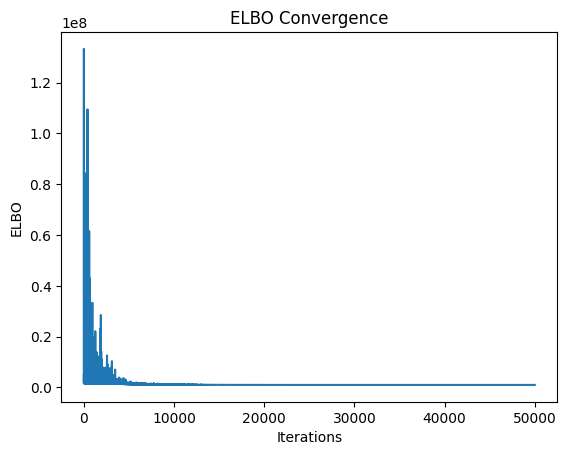

In [275]:
# elbo measure- to check how well variational approximation (advi method) matches true posterior distribution
# it needs to converge/plateau
elbo_values = approx.hist
plt.plot(elbo_values)
plt.xlabel('Iterations')
plt.ylabel('ELBO')
plt.title('ELBO Convergence')
plt.show()

## Analyze Pymc results

In [293]:
summary_df = az.summary(trace, round_to=3, stat_funcs={'median': np.median}) # beta unadjusted version
summary_df.shape

Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


(6717, 10)

In [294]:
offense_summary = summary_df.loc[summary_df.index.str.contains('beta')][:num_players_w_mins]
# add player id and player name cols
offense_summary['playerId'] = players_with_mins
offense_summary = offense_summary.merge(prior_df[['playerId','fullName','ortgPlayer']], on='playerId', how='left')
offense_summary.shape

(3324, 13)

In [295]:
print(summary_df.loc[summary_df.index.str.contains('beta')]['mean'].mean())
print(offense_summary['mean'].mean())

0.09467758749069248
0.09972563176895306


In [296]:
defense_summary = summary_df.loc[summary_df.index.str.contains('beta')][num_players_w_mins:(2*num_players_w_mins)]
defense_summary['playerId'] = players_with_mins
defense_summary = defense_summary.merge(prior_df[['playerId','fullName','drtgPlayer']], on='playerId', how='left')
defense_summary.shape

(3324, 13)

In [242]:
# top offense players - unadjusted - all train data
offense_summary.sort_values(by='mean', ascending=False).head(20)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,playerId,fullName,ortgPlayer
90,0.222,0.242,-0.240,0.661,0.008,0.005,980.308,840.673,NaN,0.218,1606325,Zach Edey,0.298646
492,0.215,0.239,-0.214,0.634,0.008,0.006,916.909,944.195,NaN,0.217,1909609,Maliq Brown,0.299115
1141,0.211,0.221,-0.199,0.610,0.007,0.005,869.045,911.981,NaN,0.206,2143538,Ben Humrichous,0.149775
2097,0.210,0.227,-0.226,0.615,0.007,0.005,920.533,907.044,NaN,0.201,1333243,Antonio Reeves,0.240596
2962,0.207,0.230,-0.211,0.653,0.007,0.005,1135.960,841.470,NaN,0.192,1602892,Latrell Wrightsell Jr.,0.316301
1197,0.206,0.230,-0.199,0.636,0.008,0.006,865.466,823.274,NaN,0.196,1587082,Jamal Shead,0.096872
442,0.200,0.231,-0.214,0.636,0.008,0.005,943.284,983.283,NaN,0.199,1382248,Ziggy Reid,0.154087
1984,0.200,0.231,-0.240,0.620,0.008,0.006,838.342,939.138,NaN,0.203,1725335,Nick Davidson,0.187543
1451,0.199,0.219,-0.242,0.557,0.007,0.005,980.719,1011.685,NaN,0.197,2113943,Reed Sheppard,0.243298
2451,0.198,0.210,-0.201,0.586,0.007,0.005,1045.773,1107.073,NaN,0.199,2122104,Brandon Davis,0.087463


In [298]:
# adjusted - all train data 800k - advi 40k - 90/10 split
offense_summary.sort_values(by='hdi_3%', ascending=False).head(10)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,playerId,fullName,ortgPlayer
90,0.287,0.030,0.231,0.341,0.001,0.000,1982.105,1858.078,NaN,0.288,1606325,Zach Edey,0.298646
1197,0.269,0.032,0.208,0.328,0.001,0.001,1943.325,2001.183,NaN,0.269,1587082,Jamal Shead,0.096872
329,0.262,0.031,0.202,0.317,0.001,0.000,2078.485,1884.924,NaN,0.263,1609363,Matthew Murrell,0.116775
1451,0.254,0.032,0.198,0.318,0.001,0.001,1932.371,1884.272,NaN,0.254,2113943,Reed Sheppard,0.243298
2268,0.242,0.030,0.189,0.303,0.001,0.001,1757.776,1922.394,NaN,0.241,1334078,Sean East II,0.105518
2097,0.249,0.030,0.189,0.303,0.001,0.001,1618.205,1612.031,NaN,0.250,1333243,Antonio Reeves,0.240596
3021,0.251,0.034,0.188,0.317,0.001,0.001,1899.371,1960.808,NaN,0.251,1603259,Koby Brea,0.293589
1203,0.238,0.030,0.186,0.300,0.001,0.000,1995.825,1943.701,NaN,0.238,1587214,JaCobi Wood,0.100267
3169,0.238,0.029,0.185,0.296,0.001,0.000,2156.163,1967.464,NaN,0.239,1309489,Xavier Johnson,0.108126
3276,0.243,0.032,0.185,0.304,0.001,0.001,1973.642,1924.090,NaN,0.243,1408735,Enrique Freeman,0.190063


In [297]:
# top offense players - adjusted - all train data 800k - advi 40k - 90/10 split
offense_summary.sort_values(by='mean', ascending=False).head(20) # amarr knox with -0.04 ortg in 7th place??
# is it better to order by 'hdi_3%'?

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,playerId,fullName,ortgPlayer
90,0.287,0.030,0.231,0.341,0.001,0.000,1982.105,1858.078,NaN,0.288,1606325,Zach Edey,0.298646
1197,0.269,0.032,0.208,0.328,0.001,0.001,1943.325,2001.183,NaN,0.269,1587082,Jamal Shead,0.096872
329,0.262,0.031,0.202,0.317,0.001,0.000,2078.485,1884.924,NaN,0.263,1609363,Matthew Murrell,0.116775
1451,0.254,0.032,0.198,0.318,0.001,0.001,1932.371,1884.272,NaN,0.254,2113943,Reed Sheppard,0.243298
3021,0.251,0.034,0.188,0.317,0.001,0.001,1899.371,1960.808,NaN,0.251,1603259,Koby Brea,0.293589
2097,0.249,0.030,0.189,0.303,0.001,0.001,1618.205,1612.031,NaN,0.250,1333243,Antonio Reeves,0.240596
1742,0.243,0.045,0.163,0.329,0.001,0.001,2108.326,2002.870,NaN,0.244,1920144,Amarr Knox,-0.044287
3276,0.243,0.032,0.185,0.304,0.001,0.001,1973.642,1924.090,NaN,0.243,1408735,Enrique Freeman,0.190063
2268,0.242,0.030,0.189,0.303,0.001,0.001,1757.776,1922.394,NaN,0.241,1334078,Sean East II,0.105518
1984,0.242,0.032,0.181,0.300,0.001,0.001,1813.819,2026.781,NaN,0.242,1725335,Nick Davidson,0.187543


In [283]:
# top offense players - adjusted - all train data 800k - advi 50k - beta's sd same as advi 40k!!
offense_summary.sort_values(by='mean', ascending=False).head(20)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,playerId,fullName,ortgPlayer
90,0.288,0.032,0.233,0.354,0.001,0.001,1836.072,1847.977,NaN,0.288,1606325,Zach Edey,0.298646
536,0.258,0.035,0.193,0.323,0.001,0.001,1947.492,1919.043,NaN,0.258,1383379,Nick Caldwell,0.130504
1203,0.258,0.030,0.201,0.315,0.001,0.000,2040.573,1961.736,NaN,0.259,1587214,JaCobi Wood,0.100267
1894,0.251,0.033,0.190,0.309,0.001,0.001,2012.588,2000.214,NaN,0.250,1691840,Wade Taylor IV,0.071117
1451,0.248,0.033,0.182,0.309,0.001,0.001,2140.061,1655.739,NaN,0.247,2113943,Reed Sheppard,0.243298
2268,0.247,0.032,0.190,0.308,0.001,0.000,2053.230,1962.492,NaN,0.247,1334078,Sean East II,0.105518
1141,0.242,0.038,0.171,0.311,0.001,0.001,2026.859,1920.108,NaN,0.242,2143538,Ben Humrichous,0.149775
343,0.241,0.035,0.175,0.303,0.001,0.001,2116.056,1812.582,NaN,0.241,1314548,Eric Dixon,0.119205
3121,0.239,0.032,0.180,0.297,0.001,0.000,2137.807,1877.148,NaN,0.239,1604009,Coleman Hawkins,0.173813
1704,0.239,0.031,0.185,0.298,0.001,0.001,1820.464,1959.928,NaN,0.238,1329676,Jamir Chaplin,0.252714


In [272]:
# top offense players - adjusted - all train data 800k - advi 40k - beta's sd has decreased!!
offense_summary.sort_values(by='mean', ascending=False).head(20)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,playerId,fullName,ortgPlayer
90,0.284,0.032,0.224,0.340,0.001,0.001,1003.848,739.875,NaN,0.285,1606325,Zach Edey,0.298646
1203,0.260,0.031,0.200,0.312,0.001,0.001,1028.143,1016.989,NaN,0.261,1587214,JaCobi Wood,0.100267
536,0.256,0.036,0.187,0.321,0.001,0.001,898.235,831.190,NaN,0.255,1383379,Nick Caldwell,0.130504
1894,0.252,0.030,0.197,0.310,0.001,0.001,947.894,883.023,NaN,0.252,1691840,Wade Taylor IV,0.071117
1451,0.248,0.034,0.176,0.305,0.001,0.001,994.574,875.689,NaN,0.247,2113943,Reed Sheppard,0.243298
1141,0.246,0.037,0.176,0.312,0.001,0.001,962.939,937.733,NaN,0.246,2143538,Ben Humrichous,0.149775
2268,0.244,0.032,0.189,0.309,0.001,0.001,887.423,922.999,NaN,0.246,1334078,Sean East II,0.105518
1704,0.243,0.031,0.189,0.305,0.001,0.001,889.605,841.470,NaN,0.242,1329676,Jamir Chaplin,0.252714
343,0.243,0.032,0.183,0.301,0.001,0.001,935.580,976.048,NaN,0.242,1314548,Eric Dixon,0.119205
2338,0.242,0.031,0.185,0.300,0.001,0.001,941.199,847.036,NaN,0.242,1924292,Jack Forrest,0.009776


In [262]:
# top offense players - adjusted - all train data 800k - advi 20k
offense_summary.sort_values(by='mean', ascending=False).head(20)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,playerId,fullName,ortgPlayer
90,0.283,0.067,0.156,0.401,0.002,0.002,995.960,828.864,NaN,0.283,1606325,Zach Edey,0.298646
536,0.258,0.073,0.130,0.396,0.002,0.002,918.092,936.770,NaN,0.259,1383379,Nick Caldwell,0.130504
1894,0.256,0.065,0.127,0.371,0.002,0.002,958.704,905.832,NaN,0.259,1691840,Wade Taylor IV,0.071117
1203,0.251,0.064,0.131,0.372,0.002,0.001,1125.223,983.445,NaN,0.250,1587214,JaCobi Wood,0.100267
2268,0.245,0.063,0.125,0.356,0.002,0.002,820.554,913.729,NaN,0.246,1334078,Sean East II,0.105518
1451,0.245,0.063,0.128,0.364,0.002,0.001,967.061,944.564,NaN,0.247,2113943,Reed Sheppard,0.243298
3121,0.240,0.069,0.121,0.379,0.002,0.002,892.363,847.400,NaN,0.240,1604009,Coleman Hawkins,0.173813
2637,0.235,0.065,0.112,0.354,0.002,0.002,982.989,749.233,NaN,0.233,1600136,Pelle Larsson,0.185696
343,0.234,0.063,0.114,0.350,0.002,0.001,1017.182,1010.740,NaN,0.235,1314548,Eric Dixon,0.119205
2097,0.234,0.063,0.108,0.346,0.002,0.001,1113.543,855.012,NaN,0.232,1333243,Antonio Reeves,0.240596


In [252]:
# top offense players - adjusted - all train data 800k
offense_summary.sort_values(by='mean', ascending=False).head(20)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,playerId,fullName,ortgPlayer
90,0.218,0.243,-0.218,0.681,0.008,0.006,965.844,943.032,NaN,0.226,1606325,Zach Edey,0.298646
2962,0.210,0.219,-0.197,0.616,0.007,0.005,925.935,684.528,NaN,0.211,1602892,Latrell Wrightsell Jr.,0.316301
1894,0.205,0.221,-0.178,0.626,0.007,0.005,965.918,988.866,NaN,0.201,1691840,Wade Taylor IV,0.071117
465,0.205,0.213,-0.237,0.561,0.007,0.005,843.090,980.871,NaN,0.198,1906894,Richie Saunders,0.274101
1984,0.203,0.237,-0.212,0.654,0.007,0.005,1047.235,1021.468,NaN,0.205,1725335,Nick Davidson,0.187543
1375,0.201,0.202,-0.179,0.569,0.006,0.005,986.952,748.850,NaN,0.207,1687558,Noah Robledo,0.084479
2268,0.201,0.214,-0.185,0.583,0.007,0.005,974.065,943.759,NaN,0.199,1334078,Sean East II,0.105518
1451,0.199,0.223,-0.255,0.591,0.007,0.005,1029.685,860.079,NaN,0.201,2113943,Reed Sheppard,0.243298
86,0.198,0.234,-0.232,0.620,0.007,0.005,1057.455,973.333,NaN,0.194,1606251,Tristan da Silva,0.149318
3121,0.196,0.233,-0.238,0.614,0.008,0.006,847.696,974.519,NaN,0.192,1604009,Coleman Hawkins,0.173813


In [164]:
# top offense players- adjusted - 100k train data
offense_summary.sort_values(by='mean', ascending=False).head(20)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,playerId,fullName,ortgPlayer
2038,0.222,0.072,0.092,0.358,0.002,0.002,947.731,906.126,NaN,0.223,2118980,Keonte Jones,0.072133
1517,0.222,0.086,0.053,0.381,0.003,0.002,994.550,881.388,NaN,0.223,1683428,Chris Manon,0.121641
3037,0.213,0.073,0.070,0.340,0.002,0.002,952.838,763.178,NaN,0.212,1605328,A.J. McGinnis,0.062664
1591,0.212,0.069,0.067,0.325,0.002,0.002,953.030,937.281,NaN,0.214,1691840,Wade Taylor IV,0.067010
2611,0.212,0.063,0.095,0.328,0.002,0.001,944.499,844.856,NaN,0.213,1383090,Ta'lon Cooper,0.228514
621,0.208,0.063,0.089,0.331,0.002,0.001,972.417,767.655,NaN,0.210,1377563,Dae Dae Grant,0.147792
3102,0.208,0.078,0.059,0.350,0.002,0.002,1029.967,774.977,NaN,0.208,1924956,Xaivian Lee,0.142525
1851,0.207,0.072,0.068,0.343,0.002,0.002,946.990,1023.715,NaN,0.208,2093931,Jordan O'Neal,0.171114
1701,0.206,0.080,0.052,0.349,0.003,0.002,1014.796,1010.740,NaN,0.204,1585646,Kylen Milton,0.177346
2586,0.203,0.074,0.056,0.331,0.002,0.002,1055.690,1025.747,NaN,0.204,1587810,Beon Riley,0.108594


In [299]:
# top defensive players - adjusted all 800k rows of data - advi 40k - 90/10 split
defense_summary.sort_values(by='mean', ascending=True).head(20)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,playerId,fullName,drtgPlayer
185,-0.077,0.042,-0.151,0.008,0.001,0.001,1835.221,1884.634,NaN,-0.076,1607499,Ja'Von Benson,-0.037512
2930,-0.068,0.040,-0.147,0.003,0.001,0.001,1898.552,1728.819,NaN,-0.067,1930365,Carson Cooper,-0.075802
2228,-0.065,0.039,-0.141,0.005,0.001,0.001,1974.562,1722.642,NaN,-0.066,1694218,Ja'Vier Francis,-0.203178
133,-0.057,0.043,-0.134,0.023,0.001,0.001,1992.745,1836.711,NaN,-0.057,1705237,Kacper Klaczek,-0.029223
145,-0.050,0.048,-0.143,0.035,0.001,0.001,1975.747,2000.214,NaN,-0.050,1705319,Nate Tshimanga,-0.086334
2246,-0.049,0.035,-0.113,0.015,0.001,0.001,1985.603,1944.716,NaN,-0.049,1333910,Airion Simmons,-0.073573
2147,-0.047,0.045,-0.128,0.037,0.001,0.001,1985.758,2003.885,NaN,-0.047,1890511,Antwone Woolfolk,-0.095416
2058,-0.045,0.046,-0.132,0.039,0.001,0.001,2045.197,1910.762,NaN,-0.045,1726217,Fousseyni Traore,-0.085639
2055,-0.044,0.052,-0.144,0.053,0.001,0.001,2092.295,1574.550,NaN,-0.045,1726181,Atiki Ally Atiki,-0.082416
3286,-0.041,0.047,-0.128,0.043,0.001,0.001,1946.345,1953.735,NaN,-0.041,950050,Parker Fox,-0.027333


In [284]:
# top defensive players - adjusted all 800k rows of data - advi 50k
defense_summary.sort_values(by='mean', ascending=True).head(20)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,playerId,fullName,drtgPlayer
2930,-0.079,0.041,-0.155,-0.004,0.001,0.001,1999.807,1818.217,NaN,-0.079,1930365,Carson Cooper,-0.075802
133,-0.071,0.044,-0.153,0.013,0.001,0.001,1833.190,1959.928,NaN,-0.071,1705237,Kacper Klaczek,-0.029223
185,-0.064,0.047,-0.148,0.027,0.001,0.001,1962.298,1901.814,NaN,-0.064,1607499,Ja'Von Benson,-0.037512
2147,-0.049,0.049,-0.140,0.048,0.001,0.001,1958.360,1751.559,NaN,-0.048,1890511,Antwone Woolfolk,-0.095416
2246,-0.047,0.036,-0.111,0.019,0.001,0.001,2012.081,1858.275,NaN,-0.046,1333910,Airion Simmons,-0.073573
1360,-0.046,0.044,-0.129,0.038,0.001,0.001,1970.173,2092.693,NaN,-0.048,1720267,Lawson Lovering,-0.042184
2228,-0.046,0.040,-0.120,0.034,0.001,0.001,2055.824,2004.139,NaN,-0.046,1694218,Ja'Vier Francis,-0.203178
2058,-0.045,0.050,-0.141,0.047,0.001,0.001,1964.759,1962.492,NaN,-0.045,1726217,Fousseyni Traore,-0.085639
381,-0.044,0.045,-0.130,0.036,0.001,0.001,1897.301,1931.260,NaN,-0.045,2134400,Ubong Okon,-0.100093
2055,-0.042,0.054,-0.155,0.050,0.001,0.001,1631.526,1788.297,NaN,-0.044,1726181,Atiki Ally Atiki,-0.082416


In [263]:
# top defensive players - adjusted all 800k rows of data - advi 20k
defense_summary.sort_values(by='mean', ascending=True).head(20)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,playerId,fullName,drtgPlayer
133,-0.076,0.066,-0.199,0.049,0.002,0.001,1024.552,880.241,NaN,-0.078,1705237,Kacper Klaczek,-0.029223
2930,-0.073,0.065,-0.194,0.048,0.002,0.001,987.755,1016.203,NaN,-0.073,1930365,Carson Cooper,-0.075802
185,-0.072,0.067,-0.194,0.054,0.002,0.001,1056.981,983.445,NaN,-0.071,1607499,Ja'Von Benson,-0.037512
2147,-0.054,0.063,-0.161,0.073,0.002,0.001,979.959,907.154,NaN,-0.056,1890511,Antwone Woolfolk,-0.095416
381,-0.053,0.067,-0.181,0.073,0.002,0.002,967.384,804.237,NaN,-0.054,2134400,Ubong Okon,-0.100093
2228,-0.049,0.065,-0.170,0.078,0.002,0.002,979.648,831.190,NaN,-0.050,1694218,Ja'Vier Francis,-0.203178
2246,-0.046,0.064,-0.165,0.071,0.002,0.001,965.170,937.281,NaN,-0.047,1333910,Airion Simmons,-0.073573
1360,-0.043,0.067,-0.177,0.077,0.002,0.002,927.846,908.097,NaN,-0.041,1720267,Lawson Lovering,-0.042184
1102,-0.041,0.064,-0.153,0.087,0.002,0.001,1007.303,845.531,NaN,-0.041,1324050,Juwan Gary,-0.060114
989,-0.040,0.069,-0.178,0.085,0.002,0.002,918.245,723.443,NaN,-0.038,1715838,Valentin Catt,-0.081007


In [254]:
# top defensive players - adjusted all 800k rows of data
defense_summary.sort_values(by='mean', ascending=True).head(20)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,playerId,fullName,drtgPlayer
185,-0.044,0.213,-0.408,0.355,0.007,0.005,1059.989,794.475,NaN,-0.045,1607499,Ja'Von Benson,-0.037512
2147,-0.042,0.208,-0.456,0.312,0.007,0.005,974.060,983.673,NaN,-0.039,1890511,Antwone Woolfolk,-0.095416
2930,-0.039,0.223,-0.441,0.360,0.007,0.005,1040.214,993.680,NaN,-0.046,1930365,Carson Cooper,-0.075802
133,-0.036,0.206,-0.456,0.317,0.007,0.005,893.484,1023.066,NaN,-0.035,1705237,Kacper Klaczek,-0.029223
1268,-0.032,0.208,-0.406,0.358,0.006,0.005,1074.428,878.826,NaN,-0.036,2112512,"Maurice Wright, Jr.",0.042676
1727,-0.028,0.215,-0.393,0.434,0.007,0.005,1020.547,983.283,NaN,-0.035,1723397,Nate Barnhart,-0.034872
2157,-0.026,0.186,-0.395,0.312,0.006,0.004,1012.910,1021.848,NaN,-0.031,1890527,Terrance Arceneaux,-0.175925
2055,-0.023,0.200,-0.367,0.364,0.006,0.004,1047.198,835.558,NaN,-0.023,1726181,Atiki Ally Atiki,-0.082416
1590,-0.022,0.207,-0.401,0.398,0.007,0.005,991.146,1017.252,NaN,-0.024,1622956,Babacar Diallo,-0.052508
381,-0.022,0.215,-0.406,0.390,0.007,0.005,959.494,908.228,NaN,-0.027,2134400,Ubong Okon,-0.100093


In [163]:
# top defensive players - adjusted 100k rows of data
defense_summary.sort_values(by='mean', ascending=True).head(20)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,playerId,fullName,drtgPlayer
1517,-0.097,0.082,-0.243,0.060,0.002,0.002,1140.312,1016.989,NaN,-0.097,1683428,Chris Manon,-0.093018
3045,-0.082,0.094,-0.241,0.097,0.003,0.002,757.644,732.317,NaN,-0.080,1605337,Blaise Threatt,-0.042926
580,-0.075,0.099,-0.261,0.103,0.003,0.002,946.801,983.283,NaN,-0.075,1401969,Tyler Henry,-0.051396
372,-0.071,0.097,-0.269,0.103,0.003,0.002,924.553,980.871,NaN,-0.072,2138836,Sean Stewart,-0.166251
2163,-0.069,0.086,-0.219,0.097,0.003,0.002,956.868,921.327,NaN,-0.071,1726181,Atiki Ally Atiki,-0.081386
176,-0.067,0.087,-0.236,0.090,0.003,0.002,1052.873,840.653,NaN,-0.068,1925483,AJ Cajuste,-0.038111
480,-0.067,0.093,-0.228,0.131,0.003,0.002,1037.995,971.769,NaN,-0.067,1917826,Elijah Walsh,0.004100
2259,-0.067,0.079,-0.208,0.088,0.003,0.002,952.636,979.432,NaN,-0.066,1701842,KJ Allen,-0.044099
3127,-0.066,0.076,-0.196,0.096,0.002,0.002,974.411,939.138,NaN,-0.067,1605522,Kenny Hunter,-0.031060
2192,-0.060,0.085,-0.224,0.098,0.003,0.002,1001.493,982.799,NaN,-0.059,1726242,Grant Asman,0.016973
